In [28]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_balanced_smote+rund-10m.csv', low_memory = False)

In [29]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [26, 25]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [30]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [31]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [32]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [33]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [34]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [35]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [36]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [37]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [38]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [39]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [40]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [41]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 5,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = 0.001,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = 5,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate 
        min_alpha = 0.0001,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])
    
    return model

In [42]:
curr_model = training(sentences_series_np_train)

Validation loss decreased (inf --> 103813.226562).  Saving model ...
Validation loss decreased (103813.226562 --> 53530.992188).  Saving model ...
Validation loss decreased (53530.992188 --> 48578.718750).  Saving model ...
Validation loss decreased (48578.718750 --> 46388.984375).  Saving model ...
Validation loss decreased (46388.984375 --> 43358.703125).  Saving model ...
Validation loss decreased (43358.703125 --> 42831.093750).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (42831.093750 --> 39030.656250).  Saving model ...
Validation loss decreased (39030.656250 --> 37877.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (37877.625000 --> 37077.500000).  Saving model ...
Validation loss decreased (37077.500000 --> 36682.375000).  Saving model ...
Validation loss decreased (36682.375000 --> 36274.062500).  Saving model ...
EarlyStopping counte

In [43]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [44]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.append(curr_prob)

    return predictions, predictions_prob

In [45]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [46]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [48]:
#call predictions
prevs, prevs_prob = predict(curr_model, sentences_series_np_test, verbose1 = True, verbose2 = True)

['nbe', 'trfsep', 'c9809887', 'e3', 'r3', 'ntrusted', 'io9529158', 'id3886053', 'icnkapb', 'fraud', 'ecdarb', 'ip944672930', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 21838, 21839, 35, 8, 28, 21840, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0009837411707849242
Non Fraud prob: 0.0009832044670474716
['mbp', 'trfint', 'c2148651', 'e3', 'r3', 'ntrusted', 'io2148653', 'id2148652', 'nkapi', 'nfraud', 'negaccount', 'ip217129181145', 'other', 'android', 'earlymorning', 'w36', 'tue', 'sep', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 21842, 21843, 81, 9, 24, 21844, 29, 20, 86, 121, 27, 55, 31]
Fraud prob: 0.0009416464872629149
Non Fraud prob: 0.0009428195444343146
['nbe', 'trfsep', 'c3059291', 'e3', 'r3', 'ntrusted', 'io3059292', 'id16997966', 'icnkapb', 'fraud', 'ecdarb', 'ip194065022', 'chrome', 'windows', 'morning', 'w19', 'thu', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 21846, 21847, 35, 8, 28, 21848, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0010242381

Transaction: [11, 7, 0, 1, 2, 21914, 21915, 35, 8, 37, 21916, 5, 4, 6, 14, 12, 21, 3]
Fraud prob: 0.0009144623581960332
Non Fraud prob: 0.0009148181379714515
['nbp', 'trfsep', 'c10234899', 'e3', 'r3', 'ntrusted', 'io5859331', 'id10234505', 'kapbin', 'fraud', 'darbe', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 2, 21918, 168, 48, 8, 50, 155, 5, 4, 44, 74, 12, 47, 3]
Fraud prob: 0.0015996154434105847
Non Fraud prob: 0.0015889163441897836
['nbp', 'trfsep', 'c16086515', 'e3', 'r3', 'ntrusted', 'io16086517', 'id16241253', 'nkapbic', 'fraud', 'ecdarb', 'ip196119111182', 'chrome', 'windows', 'morning', 'w17', 'wed', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 2, 21920, 94, 39, 8, 28, 83, 5, 4, 6, 54, 26, 21, 3]
Fraud prob: 0.0010126488195965067
Non Fraud prob: 0.0010149402987735812
['nbe', 'trfsep', 'c8250259', 'e3', 'r3', 'ntrusted', 'io2752455', 'id16428954', 'icnkapb', 'fraud', 'cdarbe', 'ip1486340105', 'chrome', 'windows', 'morning', 'w

Transaction: [11, 7, 0, 1, 2, 21999, 22000, 45, 9, 64, 22001, 5, 4, 6, 75, 25, 33, 3]
Fraud prob: 0.0010531630614423193
Non Fraud prob: 0.0010540782368479995
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'inkapb', 'fraud', 'negaccount', 'ip95483504', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 62, 8, 24, 22002, 5, 20, 6, 14, 12, 13, 23]
Fraud prob: 0.06033252569311314
Non Fraud prob: 0.060332528063126105
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'apbink', 'fraud', 'arbecd', 'ip8911588237', 'chrome', 'windows', 'morning', 'w19', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 2, 187, 246, 43, 8, 52, 188, 5, 4, 6, 14, 12, 47, 3]
Fraud prob: 0.01334937794694253
Non Fraud prob: 0.013349400141832012
['nbe', 'trfsep', 'c1742318', 'e3', 'r3', 'trusted', 'io985307', 'id2045419', 'icnkapb', 'fraud', 'darbecd', 'ip5973084346', 'chrome', 'windows', 'afternoon', 'w19',

Transaction: [19, 7, 0, 1, 2, 22083, 22084, 48, 9, 24, 22085, 29, 20, 18, 88, 12, 49, 31]
Fraud prob: 0.0013290178503666539
Non Fraud prob: 0.0013267304384498857
['nbe', 'trfsep', 'c1136645', 'e3', 'r3', 'trusted', 'io1039942', 'id1537361', 'nkapbic', 'nfraud', 'arbecdd', 'ip37189167134', 'chrome', 'windows', 'dusk', 'w39', 'mon', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 17, 22087, 22088, 39, 9, 64, 22089, 5, 4, 22, 119, 12, 55, 3]
Fraud prob: 0.0010521976473683026
Non Fraud prob: 0.0010526717742322944
['nbp', 'trfsep', 'c2272196', 'e3', 'r3', 'ntrusted', 'io2255238', 'id6813419', 'pbinka', 'fraud', 'darbec', 'ip89460555', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 22091, 22092, 45, 8, 40, 22093, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010302987320756074
Non Fraud prob: 0.0010329783472116105
['nbe', 'trfsep', 'c1172768', 'e3', 'r3', 'trusted', 'io1172770', 'id2450565', 'nkapbic', 'nfraud', 'becdar', 'ip149902043', 'chrome', 'windows', 'aftern

Transaction: [10, 15, 0, 1, 17, 22150, 22151, 43, 9, 50, 22152, 5, 4, 22, 117, 27, 55, 3]
Fraud prob: 0.001154811692686053
Non Fraud prob: 0.0011524823239597026
['nbp', 'trfint', 'c13361374', 'e3', 'r3', 'ntrusted', 'io1950027', 'id909739', 'nkapbi', 'nfraud', 'negaccount', 'ip85247106121', 'chrome', 'windows', 'morning', 'w14', 'fri', 'apr', 'pc']
Transaction: [10, 15, 0, 1, 2, 22154, 22155, 42, 9, 24, 22156, 5, 4, 6, 88, 32, 21, 3]
Fraud prob: 0.0010153714338230202
Non Fraud prob: 0.001016287797028781
['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'bicnkap', 'fraud', 'arbecd', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 171, 175, 30, 8, 52, 176, 66, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.03234728886367843
Non Fraud prob: 0.032347296730249823
['nbe', 'trfsep', 'c3149178', 'e3', 'r3', 'ntrusted', 'io3149179', 'id14254377', 'bicnkap', 'fraud', 'arbecd', 'ip945991066', 'chrome', 'windows', 'morning', '

Transaction: [19, 7, 0, 1, 2, 22229, 22230, 61, 9, 24, 22231, 34, 38, 22, 59, 25, 21, 23]
Fraud prob: 0.0010336644263588823
Non Fraud prob: 0.0010355155427532736
['nbp', 'trfsep', 'c5419223', 'e3', 'r3', 'ntrusted', 'io7061344', 'id7098307', 'icnkapb', 'fraud', 'arbed', 'ip99086805', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 22233, 22234, 35, 8, 65, 22235, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000837603543914156
Non Fraud prob: 0.0008345495043613482
['nbe', 'trfips', 'c16900657', 'e3', 'r3', 'ntrusted', 'io14574465', 'id16683924', 'icnkapb', 'fraud', 'becdar', 'ip51574602', 'chrome', 'windows', 'morning', 'w19', 'thu', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 22237, 22238, 35, 8, 36, 22239, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0009039401975314831
Non Fraud prob: 0.0009072594093595399
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'icnkapb', 'fraud', 'becdar', 'ip1682322070', 'chrome', 'windows', 'after

Transaction: [19, 15, 0, 1, 2, 22302, 22303, 56, 9, 24, 22304, 34, 38, 18, 98, 68, 49, 23]
Fraud prob: 0.0007483324425265891
Non Fraud prob: 0.0007509711813327158
['nbp', 'trfsep', 'c4007822', 'e3', 'r3', 'ntrusted', 'io16808264', 'id17032029', 'cnkapbi', 'fraud', 'darbec', 'ip28323457', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 22306, 22307, 46, 8, 40, 22308, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007770806987537071
Non Fraud prob: 0.0007759695836284664
['mbp', 'trfint', 'c3746295', 'e3', 'r3', 'ntrusted', 'io5710473', 'id3746297', 'inkap', 'nfraud', 'bedar', 'ip1486915252', 'other', 'android', 'dusk', 'w45', 'fri', 'nov', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 22310, 22311, 61, 9, 77, 22312, 29, 20, 22, 106, 32, 57, 31]
Fraud prob: 0.001213235063914908
Non Fraud prob: 0.0012136676432419335
['nbe', 'trfsep', 'c2331295', 'e3', 'r3', 'ntrusted', 'io2331296', 'id2479041', 'kapbin', 'nfraud', 'ecdarb', 'ip959511236', 'firefox', 'macosx', '

Transaction: [11, 7, 0, 1, 2, 22386, 22387, 60, 8, 69, 22388, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010285111220582621
Non Fraud prob: 0.0010293945997545961
['nbe', 'trfsep', 'c1234989', 'e3', 'r3', 'ntrusted', 'io1234990', 'id4928095', 'kapbin', 'nfraud', 'ecdarb', 'ip8490664', 'safari', 'macosx', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 22390, 22391, 48, 9, 28, 22392, 34, 73, 18, 63, 12, 33, 3]
Fraud prob: 0.0008088635422609514
Non Fraud prob: 0.0008069679442996858
['nbp', 'trfint', 'c3393704', 'e3', 'r3', 'trusted', 'io617390', 'id617441', 'pbinka', 'nfraud', 'negaccount', 'ip85240163121', 'chrome', 'windows', 'morning', 'w14', 'thu', 'apr', 'pc']
Transaction: [10, 15, 0, 1, 17, 22394, 22395, 45, 9, 24, 22396, 5, 4, 6, 88, 25, 21, 3]
Fraud prob: 0.0012725635806418722
Non Fraud prob: 0.00127203629926953
['mbp', 'trfsep', 'c2640544', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11660756', 'icnkapb', 'fraud', 'negaccount', 'ip1682322070', 'other', 'android', 'du

Transaction: [10, 16, 0, 1, 2, 22458, 22459, 35, 8, 37, 20991, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008377350422961172
Non Fraud prob: 0.0008407389104831964
['nbe', 'trfsep', 'c6683008', 'e3', 'r3', 'ntrusted', 'io11303927', 'id12081776', 'cnkapbi', 'fraud', 'darbe', 'ip7711124766', 'chrome', 'windows', 'dusk', 'w5', 'wed', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 22461, 225, 46, 8, 50, 204, 5, 4, 22, 75, 26, 33, 3]
Fraud prob: 0.0010087204409501282
Non Fraud prob: 0.0010089277730003232
['nbp', 'trfsep', 'c8113257', 'e3', 'r3', 'ntrusted', 'io101425', 'id464698', 'icnkapb', 'nfraud', 'cdarbe', 'ip94252122199', 'edge', 'windows', 'afternoon', 'w12', 'wed', 'mar', 'pc']
Transaction: [10, 7, 0, 1, 2, 22463, 22464, 35, 9, 37, 22465, 66, 4, 18, 118, 26, 49, 3]
Fraud prob: 0.000854212505146279
Non Fraud prob: 0.0008574433941248572
['nbe', 'trfsep', 'c799748', 'e3', 'r3', 'trusted', 'io799749', 'id5049766', 'icnkapb', 'nfraud', 'arbecd', 'ip188251183252', 'firefox', 'windows', 'afternoon'

Transaction: [10, 16, 0, 1, 2, 22531, 22532, 30, 8, 52, 156, 5, 73, 6, 85, 12, 21, 3]
Fraud prob: 0.0009482990462856833
Non Fraud prob: 0.000948946788412286
['nbe', 'trfips', 'c1773428', 'e3', 'r3', 'ntrusted', 'io855761', 'id13614952', 'pbicnka', 'fraud', 'becdar', 'ip8524201251', 'chrome', 'windows', 'morning', 'w19', 'thu', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 22534, 22535, 60, 8, 36, 22536, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0011260048031545011
Non Fraud prob: 0.00112983998224081
['mbp', 'trfmbw', 'c2032145', 'e3', 'r3', 'ntrusted', 'io2032147', 'id15407203', 'inkapb', 'nfraud', 'negaccount', 'ip1094996165', 'safari', 'ios', 'night', 'w14', 'sat', 'apr', 'tmobile']
Transaction: [19, 137, 0, 1, 2, 22538, 22539, 62, 9, 24, 22540, 34, 38, 44, 88, 68, 21, 23]
Fraud prob: 0.0009427221630176064
Non Fraud prob: 0.000943652012210805
['nbp', 'trfsep', 'c4459588', 'e3', 'r3', 'ntrusted', 'io76096', 'id13614045', 'nkapbic', 'fraud', 'darbe', 'ip51541741', 'chrome', 'android', 'dusk'

Transaction: [10, 16, 0, 1, 2, 22615, 22616, 35, 8, 37, 22617, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.001004953102892614
Non Fraud prob: 0.0010050618711829884
['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'binkap', 'fraud', 'negaccount', 'ip1486957236', 'safari', 'ios', 'morning', 'w14', 'tue', 'mar', 'tmobile']
Transaction: [19, 7, 0, 1, 2, 304, 216, 56, 8, 24, 696, 34, 38, 6, 88, 27, 49, 23]
Fraud prob: 0.0006982330546448223
Non Fraud prob: 0.0006981301295736897
['mbp', 'trfmbw', 'c7698376', 'e3', 'r3', 'ntrusted', 'io7698377', 'id16626760', 'nkapbi', 'nfraud', 'negaccount', 'ip8524556229', 'safari', 'ios', 'dusk', 'w20', 'sun', 'may', 'tmobile']
Transaction: [19, 137, 0, 1, 2, 22619, 22620, 42, 9, 24, 22621, 34, 38, 22, 71, 67, 13, 23]
Fraud prob: 0.0009904237167575047
Non Fraud prob: 0.000991714498923102
['nbp', 'trfips', 'c3814124', 'e3', 'r3', 'ntrusted', 'io1123888', 'id17324009', 'bicnkap', 'fraud', 'ecdarb', 'ip1954799577', 'chrome', 'windows'

Transaction: [10, 15, 0, 1, 17, 22698, 22699, 134, 9, 50, 22700, 5, 4, 18, 96, 27, 47, 3]
Fraud prob: 0.0008419875011895783
Non Fraud prob: 0.0008453827431367245
['nbp', 'trfsep', 'c10236259', 'e3', 'r3', 'trusted', 'io10237763', 'id7152055', 'bicnkap', 'fraud', 'cdarbe', 'ip10424324298', 'chrome', 'windows', 'morning', 'w52', 'mon', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 17, 22701, 22702, 30, 8, 37, 155, 5, 4, 6, 74, 12, 47, 3]
Fraud prob: 0.005812239990055876
Non Fraud prob: 0.005812667274702652
['nbp', 'trfsep', 'c993164', 'e3', 'r3', 'trusted', 'io993165', 'id993166', 'binkap', 'nfraud', 'rbecda', 'ip8513911142', 'chrome', 'windows', 'afternoon', 'w35', 'thu', 'aug', 'pc']
Transaction: [10, 7, 0, 1, 17, 22704, 22705, 56, 9, 41, 22706, 5, 4, 18, 148, 25, 79, 3]
Fraud prob: 0.0010207624500253587
Non Fraud prob: 0.0010215085339950747
['nbp', 'trfint', 'c3678316', 'e3', 'r3', 'trusted', 'io706489', 'id733215', 'apbink', 'nfraud', 'darbe', 'ip148693998', 'chrome', 'android', 'dusk', 'w

Transaction: [10, 7, 0, 1, 2, 22771, 22772, 46, 8, 36, 22773, 5, 4, 18, 75, 26, 33, 3]
Fraud prob: 0.0010356710154155735
Non Fraud prob: 0.001030687151796883
['nbe', 'trfsep', 'c825944', 'e3', 'r3', 'ntrusted', 'io51256', 'id3768417', 'cnkapbi', 'nfraud', 'rbecda', 'ip2131357127', 'chrome', 'windows', 'morning', 'w51', 'tue', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 2, 22775, 22776, 46, 9, 41, 22777, 5, 4, 6, 97, 27, 47, 3]
Fraud prob: 0.0009420964051969349
Non Fraud prob: 0.0009442456175747793
['nbe', 'trfsep', 'c907966', 'e3', 'r3', 'trusted', 'io907967', 'id1370480', 'nkapbi', 'nfraud', 'darbec', 'ip8915322654', 'chrome', 'windows', 'afternoon', 'w39', 'thu', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 17, 22779, 22780, 42, 9, 40, 8499, 5, 4, 18, 119, 25, 55, 3]
Fraud prob: 0.0008583380149502773
Non Fraud prob: 0.0008587354877818143
['nbp', 'trfsep', 'c6017404', 'e3', 'r3', 'ntrusted', 'io5263626', 'id5263627', 'bicnkap', 'fraud', 'ecdarb', 'ip20814891637', 'chrome', 'windows', 'morning'

Transaction: [10, 7, 0, 1, 2, 22852, 22853, 56, 9, 70, 22854, 53, 4, 22, 105, 27, 21, 3]
Fraud prob: 0.0010846535096789012
Non Fraud prob: 0.0010890347348322393
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'pbinka', 'fraud', 'bedar', 'ip95948495', 'chrome', 'android', 'morning', 'w17', 'fri', 'apr', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 45, 8, 77, 126, 5, 20, 6, 54, 32, 21, 23]
Fraud prob: 0.03851000776342076
Non Fraud prob: 0.038510009292536014
['nbp', 'trfsep', 'c3401840', 'e3', 'r3', 'trusted', 'io2744220', 'id3402198', 'pbinka', 'nfraud', 'darbe', 'ip144648074', 'safari', 'macosx', 'morning', 'w37', 'thu', 'sep', 'pc']
Transaction: [10, 7, 0, 1, 17, 22856, 22857, 45, 9, 50, 22858, 34, 73, 6, 89, 25, 55, 3]
Fraud prob: 0.0010725443935371004
Non Fraud prob: 0.0010732858972914983
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'pbinka', 'fraud', 'rbeda', 'ip188250170215', 'chrome', 'android', 'afternoon'

Transaction: [11, 7, 0, 1, 2, 22924, 22925, 39, 9, 69, 22926, 5, 4, 18, 161, 32, 79, 3]
Fraud prob: 0.0010469149692653446
Non Fraud prob: 0.0010395000481366878
['nbp', 'trfips', 'c15045888', 'e3', 'r3', 'ntrusted', 'io15045890', 'id15852926', 'bicnkap', 'fraud', 'arbecd', 'ip80172235158', 'chrome', 'macosx', 'morning', 'w16', 'mon', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 22928, 22929, 30, 8, 52, 156, 5, 73, 6, 85, 12, 21, 3]
Fraud prob: 0.0010657173088475247
Non Fraud prob: 0.0010627468045640853
['mbp', 'trfint', 'c2246771', 'e3', 'r3', 'ntrusted', 'io2246773', 'id12882288', 'pbinka', 'nfraud', 'negaccount', 'ip946221581', 'safari', 'ios', 'night', 'w20', 'sun', 'may', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 22931, 22932, 45, 9, 24, 22933, 34, 38, 44, 71, 67, 13, 23]
Fraud prob: 0.0009558479941915721
Non Fraud prob: 0.0009565064647176769
['nbe', 'trfsep', 'c2961895', 'e3', 'r3', 'ntrusted', 'io919230', 'id17395149', 'cnkapbi', 'fraud', 'arbecdd', 'ip51541741', 'chrome', 'windows

Transaction: [11, 16, 0, 1, 2, 22999, 23000, 60, 8, 28, 23001, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 0.0009964269556803629
Non Fraud prob: 0.0009878651690087281
['nbe', 'trfsep', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'bicnkap', 'fraud', 'rbecda', 'ip8517779179', 'chrome', 'windows', 'morning', 'w18', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 127, 78, 30, 8, 41, 23002, 5, 4, 6, 59, 12, 13, 3]
Fraud prob: 0.018036907051195844
Non Fraud prob: 0.018036908024290005
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 223, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.01944628861318198
Non Fraud prob: 0.01944629143885723
['mbp', 'trfint', 'c2046404', 'e3', 'r3', 'ntrusted', 'io13630682', 'id2046406', 'inkap', 'nfraud', 'negaccount', 'ip312216260', 'other', 'android', 'morning', 'w9', 'fri

Transaction: [10, 7, 0, 1, 17, 23063, 23064, 43, 9, 28, 23065, 5, 4, 76, 85, 68, 21, 3]
Fraud prob: 0.0008707250472070882
Non Fraud prob: 0.0008716392858332256
['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'bicnkap', 'fraud', 'rbecda', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 199, 139, 30, 8, 41, 200, 5, 4, 6, 59, 12, 21, 3]
Fraud prob: 0.014746497223363153
Non Fraud prob: 0.014746524973021724
['nbe', 'trfsep', 'c12606126', 'e3', 'r3', 'ntrusted', 'io4012130', 'id5544426', 'nkapbi', 'fraud', 'arbed', 'ip1486805349', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 23067, 23068, 42, 8, 65, 23069, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008098696216620738
Non Fraud prob: 0.000812131724160281
['mbp', 'trfsep', 'c2147062', 'e3', 'r3', 'ntrusted', 'io2147063', 'id3203894', 'inkapb', 'nfraud', 'negaccount', 'ip7754250167', 'other', 'android', 'dawn', 'w1

Transaction: [10, 7, 0, 1, 2, 23128, 23129, 46, 8, 37, 155, 5, 4, 6, 74, 12, 47, 3]
Fraud prob: 0.0012529823288787156
Non Fraud prob: 0.0012542526819743216
['nbe', 'trfips', 'c2153866', 'e3', 'r3', 'ntrusted', 'io2838122', 'id17358695', 'pbicnka', 'fraud', 'arbecdd', 'ip62283888', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 23131, 23132, 60, 8, 64, 23133, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010585309537418652
Non Fraud prob: 0.0010495382630324457
['mbp', 'trfint', 'c3563363', 'e3', 'r3', 'ntrusted', 'io3563365', 'id8388265', 'nkapbi', 'nfraud', 'negaccount', 'ip92250100123', 'safari', 'ios', 'dusk', 'w9', 'sun', 'mar', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 23135, 23136, 42, 9, 24, 23137, 34, 38, 22, 91, 67, 49, 23]
Fraud prob: 0.0007757863768347306
Non Fraud prob: 0.0007796939553372795
['mbp', 'trfint', 'c2492307', 'e3', 'r3', 'ntrusted', 'io2492308', 'id2492309', 'binkap', 'nfraud', 'negaccount', 'ip79169119193', 'other', 'android',

Transaction: [11, 16, 0, 1, 2, 23202, 23203, 60, 8, 36, 23204, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0009125980723183602
Non Fraud prob: 0.0009057097922777757
['mbp', 'trfint', 'c17173787', 'e3', 'r3', 'ntrusted', 'io13809081', 'id555542', 'apbink', 'fraud', 'negaccount', 'ip1882511290', 'other', 'android', 'afternoon', 'w20', 'tue', 'may', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 178, 177, 43, 8, 24, 166, 29, 20, 18, 71, 27, 13, 31]
Fraud prob: 0.004101869219814063
Non Fraud prob: 0.004101065701481304
['nbp', 'trfint', 'c5034076', 'e3', 'r3', 'ntrusted', 'io2134916', 'id1742369', 'inkapb', 'nfraud', 'darbe', 'ip282172186', 'chrome', 'linux', 'dusk', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 15, 0, 1, 2, 23206, 23207, 62, 9, 50, 23208, 5, 92, 22, 59, 12, 21, 3]
Fraud prob: 0.0007913612425909378
Non Fraud prob: 0.0007919402451079804
['nbe', 'trfsep', 'c1126527', 'e3', 'r3', 'ntrusted', 'io935446', 'id4698932', 'cnkapbi', 'nfraud', 'rbecda', 'ip8911515197', 'chrome', 'windows', 'earl

Transaction: [11, 7, 0, 1, 2, 23283, 23284, 48, 8, 50, 23285, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006875237277199631
Non Fraud prob: 0.00068753444156755
['mbp', 'trfint', 'c2102480', 'e3', 'r3', 'ntrusted', 'io2102482', 'id2102481', 'inkapb', 'nfraud', 'rbeda', 'ip9413298154', 'other', 'android', 'night', 'w42', 'mon', 'oct', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 23287, 23288, 62, 9, 70, 23289, 29, 20, 44, 116, 12, 58, 31]
Fraud prob: 0.001248165398465062
Non Fraud prob: 0.0012508189074651455
['mbp', 'trfsep', 'c6954381', 'e3', 'r3', 'trusted', 'io262996', 'id262997', 'nkapbi', 'nfraud', 'negaccount', 'ip2132216131', 'safari', 'ios', 'earlymorning', 'w1', 'tue', 'dec', 'tmobile']
Transaction: [19, 7, 0, 1, 17, 23291, 23292, 42, 9, 24, 23293, 34, 38, 86, 110, 27, 47, 23]
Fraud prob: 0.0007787187769281445
Non Fraud prob: 0.000783178786150529
['mbp', 'trfint', 'c2531274', 'e3', 'r3', 'ntrusted', 'io4625124', 'id2531276', 'binkap', 'nfraud', 'negaccount', 'ip282110216', 'safari', 'i

Transaction: [19, 15, 0, 1, 2, 23358, 23359, 46, 9, 65, 23360, 34, 38, 22, 143, 32, 58, 31]
Fraud prob: 0.0013120329331286484
Non Fraud prob: 0.0013055788385827327
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 223, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.016164578890330218
Non Fraud prob: 0.016164581239142474
['nbp', 'trfint', 'c5028760', 'e3', 'r3', 'ntrusted', 'io128542', 'id11262668', 'kapbin', 'nfraud', 'darbe', 'ip8815716782', 'chrome', 'windows', 'morning', 'w5', 'mon', 'jan', 'pc']
Transaction: [10, 15, 0, 1, 2, 23362, 23363, 48, 9, 50, 23364, 5, 4, 6, 75, 12, 33, 3]
Fraud prob: 0.0010929675281659001
Non Fraud prob: 0.0010946984511974733
['mbp', 'trfitc', 'c7969930', 'e3', 'r3', 'trusted', 'io180425', 'id531151', 'binkap', 'nfraud', 'negaccount', 'ip109136237208', 'other', 'android', 'dusk', '

Transaction: [11, 7, 0, 1, 2, 23437, 23438, 60, 8, 41, 23439, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010598843764455523
Non Fraud prob: 0.0010591442369332071
['nbe', 'trfsep', 'c2052412', 'e3', 'r3', 'ntrusted', 'io812054', 'id8296140', 'pbicnka', 'fraud', 'becdar', 'ip8914255883', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 23441, 23442, 60, 8, 36, 23443, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008237248284785892
Non Fraud prob: 0.0008251724675574224
['nbp', 'trfsep', 'c3751726', 'e3', 'r3', 'ntrusted', 'io1242766', 'id6865821', 'icnkapb', 'fraud', 'ecdarb', 'ip812225212', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 23445, 23446, 35, 8, 28, 23447, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000801716360001592
Non Fraud prob: 0.0008064388239290565
['nbp', 'trfsep', 'c17431501', 'e3', 'r3', 'ntrusted', 'io7548814', 'id18871838', 'nkapbic', 'nfraud', 'darbec', 'ip9594142247', 'chrome', 'windows', 'morning'

Transaction: [10, 7, 0, 1, 2, 23524, 23525, 35, 8, 37, 23526, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007917943603388267
Non Fraud prob: 0.0007961562096170383
['nbe', 'trfips', 'c11671389', 'e3', 'r3', 'ntrusted', 'io10987811', 'id11716171', 'cnkapbi', 'fraud', 'darbec', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 23528, 213, 46, 8, 40, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0008525536395609379
Non Fraud prob: 0.0008546525023120921
['nbp', 'trfips', 'c8591653', 'e3', 'r3', 'ntrusted', 'io5722143', 'id11910275', 'nkapbic', 'fraud', 'darbec', 'ip77111245852', 'chrome', 'windows', 'morning', 'w19', 'tue', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 23530, 23531, 39, 8, 40, 23532, 5, 4, 6, 14, 27, 33, 3]
Fraud prob: 0.0010496202630747575
Non Fraud prob: 0.0010442863022035453
['mbp', 'trfint', 'c2111173', 'e3', 'r3', 'ntrusted', 'io2111174', 'id2111175', 'inkap', 'nfraud', 'negaccount', 'ip89214152221', 'other', 'android', 'ea

Transaction: [10, 7, 0, 1, 2, 23586, 23587, 45, 9, 40, 23588, 80, 4, 18, 148, 32, 79, 3]
Fraud prob: 0.0010979765429510735
Non Fraud prob: 0.001098261298466241
['nbe', 'trfsep', 'c840776', 'e3', 'r3', 'tunknown', 'io840777', 'id3178076', 'nkapbic', 'nfraud', 'ecdarb', 'ip7754161137', 'chrome', 'windows', 'morning', 'w22', 'wed', 'may', 'pc']
Transaction: [11, 7, 0, 1, 183, 23590, 23591, 39, 9, 28, 23592, 5, 4, 6, 93, 26, 13, 3]
Fraud prob: 0.0008872867383615812
Non Fraud prob: 0.0008862070571922231
['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicnk', 'fraud', 'ddarbec', 'ipunknown', 'safari', 'ios', 'morning', 'w21', 'mon', 'may', 'tmobile']
Transaction: [112, 16, 0, 1, 2, 173, 179, 72, 8, 95, 113, 34, 38, 6, 82, 12, 13, 23]
Fraud prob: 0.007810379041755357
Non Fraud prob: 0.007810379232375904
['nbp', 'trfsep', 'c16291145', 'e3', 'r3', 'ntrusted', 'io2143784', 'id7767357', 'pbicnka', 'fraud', 'becdar', 'ip10278187230', 'chrome', 'windows', 'mornin

Transaction: [11, 7, 0, 1, 2, 23661, 23662, 45, 8, 77, 23663, 5, 4, 6, 14, 12, 51, 3]
Fraud prob: 0.0008042590889090206
Non Fraud prob: 0.0008051698605413549
['nbe', 'trfsep', 'c1301817', 'e3', 'r3', 'ntrusted', 'io1301818', 'id1301819', 'apbicnk', 'nfraud', 'becdar', 'ip8710312158', 'edge', 'windows', 'morning', 'w35', 'mon', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 2, 23665, 23666, 72, 9, 36, 23667, 66, 4, 6, 148, 12, 79, 3]
Fraud prob: 0.001116103156164172
Non Fraud prob: 0.001115263932661037
['nbp', 'trfsep', 'c3189340', 'e3', 'r3', 'ntrusted', 'io39865', 'id283903', 'pbinka', 'nfraud', 'edarb', 'ip2135817962', 'chrome', 'windows', 'afternoon', 'w2', 'wed', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 2, 23669, 23670, 45, 9, 132, 23671, 5, 4, 18, 104, 26, 33, 3]
Fraud prob: 0.0010789286061481107
Non Fraud prob: 0.001081195599908824
['nbp', 'trfsep', 'c3420488', 'e3', 'r3', 'ntrusted', 'io435511', 'id1767019', 'nkapbic', 'fraud', 'darbe', 'ip8204454660', 'chrome', 'windows', 'morning', 'w

Transaction: [19, 15, 0, 1, 2, 23737, 23738, 45, 9, 24, 23739, 29, 20, 22, 117, 68, 55, 31]
Fraud prob: 0.001266071156351245
Non Fraud prob: 0.001265318640434998
['nbp', 'trfsep', 'c4866327', 'e3', 'r3', 'ntrusted', 'io4866328', 'id6869703', 'kapin', 'nfraud', 'rbeda', 'ip89155197218', 'chrome', 'windows', 'morning', 'w44', 'sun', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 2, 23741, 23742, 147, 9, 70, 23743, 5, 4, 6, 109, 67, 57, 3]
Fraud prob: 0.0008088477879937273
Non Fraud prob: 0.0008068649949564133
['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'pbinka', 'fraud', 'negaccount', 'ip946215067', 'safari', 'ios', 'dusk', 'w22', 'fri', 'may', 'tmobile']
Transaction: [19, 7, 0, 1, 2, 304, 216, 45, 8, 24, 368, 34, 38, 22, 93, 32, 13, 23]
Fraud prob: 0.0006193109515318442
Non Fraud prob: 0.0006192196910144789
['nbe', 'trfips', 'c3712213', 'e3', 'r3', 'ntrusted', 'io442293', 'id16825898', 'bicnkap', 'fraud', 'rbecda', 'ip194777392', 'chrome', 'windows', 'morni

Transaction: [11, 7, 0, 1, 2, 23819, 23820, 42, 9, 50, 23821, 80, 4, 18, 98, 32, 49, 3]
Fraud prob: 0.0009341512159153353
Non Fraud prob: 0.000935494841542095
['nbp', 'trfsep', 'c7127652', 'e3', 'r3', 'trusted', 'io7127653', 'id7127654', 'nkapbi', 'nfraud', 'cdarbe', 'ip18837238155', 'chrome', 'macosx', 'night', 'w44', 'sun', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 17, 23823, 23824, 42, 9, 37, 23825, 5, 73, 44, 109, 67, 57, 3]
Fraud prob: 0.0012901780937681906
Non Fraud prob: 0.001282681983866496
['mbp', 'trfmbw', 'c2881013', 'e3', 'r3', 'ntrusted', 'io2881015', 'id16889273', 'nkapi', 'nfraud', 'negaccount', 'ip891537625', 'safari', 'ios', 'morning', 'w18', 'thu', 'apr', 'tmobile']
Transaction: [19, 137, 0, 1, 2, 23827, 23828, 81, 9, 24, 23829, 34, 38, 6, 59, 25, 21, 23]
Fraud prob: 0.0013826196736772545
Non Fraud prob: 0.0013810930468025617
['nbe', 'trfsep', 'c7055436', 'e3', 'r3', 'ntrusted', 'io2554221', 'id14781116', 'bicnkap', 'fraud', 'cdarbe', 'ip1486344096', 'chrome', 'windows'

Transaction: [10, 7, 0, 1, 2, 23905, 23906, 56, 9, 64, 23907, 5, 73, 18, 93, 32, 13, 3]
Fraud prob: 0.000768135368161893
Non Fraud prob: 0.0007680265962335397
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'nkapbi', 'fraud', 'ecdarb', 'ip9595160191', 'chrome', 'windows', 'morning', 'w19', 'sat', 'may', 'pc']
Transaction: [10, 15, 0, 1, 17, 230, 226, 42, 8, 28, 320, 5, 4, 6, 14, 68, 13, 3]
Fraud prob: 0.004464984081567581
Non Fraud prob: 0.004465154121720206
['nbp', 'trfint', 'c3125894', 'e3', 'r3', 'ntrusted', 'io137680', 'id5054036', 'binkap', 'nfraud', 'arbed', 'ip95937092', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Transaction: [10, 15, 0, 1, 2, 23909, 23910, 56, 9, 65, 23911, 5, 4, 6, 54, 27, 21, 3]
Fraud prob: 0.0008656379159219796
Non Fraud prob: 0.0008703657458681846
['nbe', 'trfips', 'c1087857', 'e3', 'r3', 'ntrusted', 'io810995', 'id15520952', 'bicnkap', 'fraud', 'arbecdd', 'ip1886816335', 'chrome', 'windows', 'morning', 'w19', 

Transaction: [19, 137, 0, 1, 2, 23983, 23984, 243, 9, 24, 23985, 34, 38, 18, 59, 25, 21, 23]
Fraud prob: 0.0007282041542566731
Non Fraud prob: 0.000721427942153241
['nbe', 'trfsep', 'c1159377', 'e3', 'r3', 'ntrusted', 'io42545', 'id7719786', 'cnkapbi', 'nfraud', 'arbecd', 'ip28125146', 'ie', 'windows', 'morning', 'w47', 'tue', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 2, 23987, 23988, 46, 9, 52, 23989, 80, 4, 6, 140, 27, 57, 3]
Fraud prob: 0.0006730085242452333
Non Fraud prob: 0.0006724496324750362
['nbe', 'trfsep', 'c1210464', 'e3', 'r3', 'ntrusted', 'io1210466', 'id4285327', 'kapbin', 'nfraud', 'ecdarb', 'ip8119372144', 'edge', 'windows', 'dusk', 'w47', 'wed', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 2, 23991, 23992, 48, 9, 28, 23993, 66, 4, 22, 140, 26, 57, 3]
Fraud prob: 0.0009933118581102462
Non Fraud prob: 0.0009929715906764613
['nbp', 'trfsep', 'c4845315', 'e3', 'r3', 'ntrusted', 'io743750', 'id16241253', 'inkapb', 'fraud', 'darbec', 'ip196119111182', 'chrome', 'windows', 'dusk', '

Transaction: [11, 7, 0, 1, 2, 24059, 24060, 46, 9, 28, 24061, 5, 4, 18, 100, 27, 57, 3]
Fraud prob: 0.0010096498317579972
Non Fraud prob: 0.001008637222184916
['mbp', 'trfint', 'c4314427', 'e3', 'r3', 'ntrusted', 'io4314429', 'id4428154', 'kapbin', 'nfraud', 'edar', 'ip3122201107', 'other', 'android', 'morning', 'w1', 'mon', 'dec', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 24063, 24064, 48, 9, 153, 24065, 29, 20, 6, 110, 12, 47, 31]
Fraud prob: 0.0012338946580712218
Non Fraud prob: 0.0012323572373134084
['nbe', 'trfsep', 'c798493', 'e3', 'r3', 'trusted', 'io799005', 'id909073', 'kapbin', 'nfraud', 'arbecd', 'ip8814188147', 'ie', 'windows', 'morning', 'w40', 'fri', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 17, 24066, 24067, 48, 9, 52, 7854, 80, 4, 6, 115, 32, 58, 3]
Fraud prob: 0.0008877457783356135
Non Fraud prob: 0.0008896931904374128
['nbe', 'trfint', 'c1174309', 'e3', 'r3', 'ntrusted', 'io1174310', 'id381921', 'apbink', 'nfraud', 'becdar', 'ip3718922027', 'chrome', 'windows', 'dusk', 

Transaction: [10, 7, 0, 1, 2, 24128, 24129, 46, 8, 28, 24130, 5, 4, 6, 14, 26, 13, 3]
Fraud prob: 0.0010895182567765005
Non Fraud prob: 0.001082451046386268
['nbp', 'trfips', 'c10313033', 'e3', 'r3', 'trusted', 'io7731058', 'id10313274', 'icnkapb', 'fraud', 'rbecda', 'ip172111133121', 'chrome', 'windows', 'morning', 'w52', 'thu', 'dec', 'pc']
Transaction: [10, 16, 0, 1, 17, 24132, 24133, 35, 8, 41, 141, 5, 4, 6, 74, 25, 47, 3]
Fraud prob: 0.0006790368333895458
Non Fraud prob: 0.000682862899338943
['nbe', 'trfsep', 'c935482', 'e3', 'r3', 'ntrusted', 'io935483', 'id10569879', 'apbicnk', 'fraud', 'darbecd', 'ip8524313389', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 24135, 24136, 72, 8, 69, 24137, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010308752152923262
Non Fraud prob: 0.0010308896780770738
['nbe', 'trfsep', 'c2890429', 'e3', 'r3', 'ntrusted', 'io3943606', 'id16330424', 'bicnkap', 'fraud', 'becdar', 'ip62284971', 'chrome', 'windows', 'morning'

Transaction: [11, 15, 0, 1, 2, 24198, 229, 72, 8, 41, 24199, 5, 4, 6, 148, 25, 79, 3]
Fraud prob: 0.0008755561593716266
Non Fraud prob: 0.0008694104635651456
['nbp', 'trfips', 'c14260191', 'e3', 'r3', 'ntrusted', 'io12780193', 'id17935694', 'icnkapb', 'fraud', 'becdar', 'ip1883713154', 'chrome', 'windows', 'dusk', 'w20', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 215, 24200, 35, 8, 36, 217, 5, 4, 22, 71, 12, 13, 3]
Fraud prob: 0.007405351241666852
Non Fraud prob: 0.007405364565323696
['nbe', 'trfips', 'c1416743', 'e3', 'r3', 'ntrusted', 'io1142627', 'id16019881', 'pbicnka', 'fraud', 'arbecd', 'ip1886061935', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 24202, 24203, 60, 8, 52, 24204, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007946997793624178
Non Fraud prob: 0.0007954275497468188
['nbp', 'trfips', 'c14477520', 'e3', 'r3', 'ntrusted', 'io13207900', 'id17630660', 'bicnkap', 'fraud', 'ecdarb', 'ip1885188226', 'chrome', 'windows', 'morning

Transaction: [19, 15, 0, 1, 2, 24282, 24283, 81, 9, 24, 24284, 29, 20, 22, 119, 67, 55, 31]
Fraud prob: 0.0008365555568161653
Non Fraud prob: 0.0008379583832720527
['mbp', 'trfint', 'c2897956', 'e3', 'r3', 'ntrusted', 'io742074', 'id5368819', 'inkapb', 'nfraud', 'ecdarb', 'ip1486959224', 'other', 'android', 'morning', 'w43', 'thu', 'oct', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 24286, 24287, 62, 9, 28, 24288, 29, 20, 6, 143, 25, 58, 31]
Fraud prob: 0.0009688695881777676
Non Fraud prob: 0.0009686101820989279
['nbp', 'trfint', 'c3815070', 'e3', 'r3', 'trusted', 'io400448', 'id400449', 'apbink', 'nfraud', 'arbed', 'ip281183212', 'other', 'windows', 'night', 'w46', 'fri', 'nov', 'otherd']
Transaction: [10, 15, 0, 1, 17, 24290, 24291, 43, 9, 65, 24292, 29, 4, 44, 114, 32, 57, 163]
Fraud prob: 0.0008107838548312429
Non Fraud prob: 0.0008110414200928062
['nbe', 'trfsep', 'c2417303', 'e3', 'r3', 'ntrusted', 'io998933', 'id1287181', 'pbicnka', 'fraud', 'rbecda', 'ip637275690', 'chrome', 'wind

Transaction: [10, 7, 0, 1, 2, 24357, 24358, 30, 8, 40, 24359, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0009602948666724842
Non Fraud prob: 0.0009604117549315561
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'cnkapbi', 'fraud', 'becdar', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 142, 144, 46, 8, 36, 102, 5, 4, 18, 63, 12, 33, 3]
Fraud prob: 0.010586662031068728
Non Fraud prob: 0.010586662508169808
['nbe', 'trfips', 'c1506612', 'e3', 'r3', 'ntrusted', 'io1506613', 'id1671425', 'apbicnk', 'fraud', 'arbecdd', 'ip144642935', 'chrome', 'windows', 'morning', 'w7', 'fri', 'feb', 'pc']
Transaction: [11, 16, 0, 1, 2, 24361, 23351, 72, 8, 64, 24362, 5, 4, 6, 108, 32, 51, 3]
Fraud prob: 0.0009917334173223935
Non Fraud prob: 0.0009949642499123001
['nbp', 'trfips', 'c4294884', 'e3', 'r3', 'ntrusted', 'io3295889', 'id15153733', 'bicnkap', 'fraud', 'cdarbe', 'ip849203801', 'chrome', 'windows', 'morning', '

Transaction: [19, 15, 0, 1, 2, 24430, 24431, 81, 9, 153, 24432, 29, 20, 6, 136, 27, 58, 31]
Fraud prob: 0.0008830345523165306
Non Fraud prob: 0.0008756727966101607
['nbe', 'trfsep', 'c1215438', 'e3', 'r3', 'ntrusted', 'io1215440', 'id3325470', 'pbicnka', 'nfraud', 'becdar', 'ip85247204243', 'firefox', 'macosx', 'afternoon', 'w9', 'mon', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 2, 24434, 24435, 60, 9, 36, 24436, 53, 73, 18, 91, 12, 51, 3]
Fraud prob: 0.0011979336795775453
Non Fraud prob: 0.0011951093310926808
['nbp', 'trfips', 'c3359577', 'e3', 'r3', 'ntrusted', 'io499172', 'id11716171', 'nkapbic', 'fraud', 'darbe', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 337, 213, 39, 8, 50, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.005863901260672354
Non Fraud prob: 0.005864137283187664
['nbe', 'trfips', 'c16662321', 'e3', 'r3', 'ntrusted', 'io6511728', 'id17360702', 'icnkapb', 'fraud', 'cdarbe', 'ip144645085', 'chrome', 'windows', 'daw

Transaction: [19, 7, 0, 1, 2, 24503, 24504, 61, 9, 24, 24505, 29, 20, 44, 54, 32, 21, 31]
Fraud prob: 0.0007207555681816302
Non Fraud prob: 0.0007232684947666712
['mbp', 'trfitc', 'c2134550', 'e3', 'r3', 'ntrusted', 'io196397', 'id6630296', 'cnkapbi', 'nfraud', 'negaccount', 'ip1486959254', 'other', 'symbianos', 'afternoon', 'w8', 'tue', 'feb', 'mobile']
Transaction: [19, 157, 0, 1, 2, 24507, 24508, 46, 9, 24, 24509, 29, 592, 18, 146, 27, 51, 447]
Fraud prob: 0.000869809542564326
Non Fraud prob: 0.0008737340594962006
['nbe', 'trfsep', 'c3432478', 'e3', 'r3', 'ntrusted', 'io421882', 'id580252', 'icnkapb', 'fraud', 'arbecd', 'ip884107460', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 24511, 24512, 35, 8, 52, 24513, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008481171680614352
Non Fraud prob: 0.0008506595622748137
['nbp', 'trfsep', 'c14408910', 'e3', 'r3', 'ntrusted', 'io11954542', 'id16574472', 'cnkapbi', 'fraud', 'cdarbe', 'ip1048236514', 'chrome'

Transaction: [11, 7, 0, 1, 17, 24571, 24572, 39, 9, 40, 24573, 53, 4, 6, 109, 27, 58, 3]
Fraud prob: 0.0008164290102286031
Non Fraud prob: 0.0008143976065184688
['mbp', 'trfsep', 'c4926593', 'e3', 'r3', 'ntrusted', 'io4926594', 'id13816274', 'inkapb', 'fraud', 'negaccount', 'ip8719680702', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [19, 7, 0, 1, 2, 24575, 24576, 62, 8, 24, 24577, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0005871813955309335
Non Fraud prob: 0.0005889156291232212
['nbe', 'trfsep', 'c3003380', 'e3', 'r3', 'ntrusted', 'io305064', 'id2203288', 'cnkapbi', 'fraud', 'darbec', 'ip83466719694', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 24579, 24580, 46, 8, 40, 24581, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007528492988058133
Non Fraud prob: 0.0007496731650462607
['mbp', 'trfsep', 'c14495616', 'e3', 'r3', 'trusted', 'io778340', 'id6811487', 'kapbin', 'nfraud', 'negaccount', 'ip79168202107', 'other', 'android',

Transaction: [19, 7, 0, 1, 2, 24646, 24647, 61, 9, 24, 24648, 29, 20, 22, 111, 25, 33, 31]
Fraud prob: 0.0006766853512090165
Non Fraud prob: 0.0006782978434785036
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'cnkapbi', 'fraud', 'becdar', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 142, 144, 46, 8, 36, 102, 5, 4, 18, 63, 12, 33, 3]
Fraud prob: 0.0097045520367897
Non Fraud prob: 0.00970455247413597
['mbp', 'trfint', 'c4577227', 'e3', 'r3', 'ntrusted', 'io18491', 'id8008783', 'apink', 'nfraud', 'negaccount', 'ip14869244117', 'other', 'android', 'afternoon', 'w11', 'thu', 'mar', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 24650, 24651, 134, 9, 24, 24652, 29, 20, 18, 90, 25, 49, 31]
Fraud prob: 0.0006280574061747757
Non Fraud prob: 0.0006314560514510958
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'kapbin', 'fraud', 'arbed', 'ip188250170215', 'chrome', 'windows

Transaction: [11, 16, 0, 1, 2, 24714, 24715, 30, 8, 36, 24716, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006913519555382663
Non Fraud prob: 0.000692647792675416
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'pbicnka', 'fraud', 'becdar', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 142, 144, 60, 8, 36, 102, 5, 4, 18, 63, 12, 33, 3]
Fraud prob: 0.009517957619624748
Non Fraud prob: 0.009517958048563244
['mbp', 'trfint', 'c3259414', 'e3', 'r3', 'ntrusted', 'io3259415', 'id3259416', 'nkapbic', 'nfraud', 'negaccount', 'ip8815773118', 'other', 'android', 'morning', 'w37', 'wed', 'sep', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 24718, 24719, 39, 9, 24, 24720, 29, 20, 6, 89, 26, 55, 31]
Fraud prob: 0.0009074058034457266
Non Fraud prob: 0.0009089535469684051
['mbp', 'trfsep', 'c6752469', 'e3', 'r3', 'ntrusted', 'io3459280', 'id2222329', 'pbinka', 'fraud', 'negaccount', 'ip946308455', 'chrome', 'windows'

Transaction: [19, 15, 0, 1, 2, 24788, 24789, 39, 9, 24, 24790, 29, 20, 76, 84, 32, 51, 31]
Fraud prob: 0.0007132530645321822
Non Fraud prob: 0.0007147361629904481
['nbp', 'trfint', 'c3414601', 'e3', 'r3', 'trusted', 'io1920922', 'id51985', 'binkap', 'nfraud', 'darbec', 'ip83240128117', 'chrome', 'windows', 'morning', 'w38', 'thu', 'sep', 'pc']
Transaction: [10, 15, 0, 1, 17, 24792, 24793, 56, 9, 40, 24794, 5, 4, 6, 117, 25, 55, 3]
Fraud prob: 0.0008740914854570292
Non Fraud prob: 0.0008713765237189364
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'inkap', 'fraud', 'edarb', 'ip95948509', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 61, 8, 132, 24795, 5, 20, 6, 14, 12, 13, 23]
Fraud prob: 0.02152628211071779
Non Fraud prob: 0.02152628295632307
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'nkapbic', 'fraud', 'cdarbe', 'ip87196118139', 'edge', 'windows', 'morning

Transaction: [10, 7, 0, 1, 2, 24847, 24848, 30, 8, 28, 24849, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 0.0007322229430428706
Non Fraud prob: 0.0007281043872353621
['nbe', 'trfint', 'c823435', 'e3', 'r3', 'trusted', 'io823436', 'id287070', 'cnkapbi', 'nfraud', 'becdar', 'ip8915535175', 'chrome', 'android', 'dawn', 'w38', 'sun', 'sep', 'tmobile']
Transaction: [11, 15, 0, 1, 17, 24851, 24852, 46, 9, 36, 24853, 5, 20, 76, 117, 67, 55, 23]
Fraud prob: 0.0008656239297124557
Non Fraud prob: 0.000857072835060535
['nbp', 'trfips', 'c4321443', 'e3', 'r3', 'ntrusted', 'io61309', 'id6466341', 'cnkapbi', 'fraud', 'darbec', 'ip1931261933', 'chrome', 'windows', 'morning', 'w43', 'fri', 'oct', 'pc']
Transaction: [10, 16, 0, 1, 2, 631, 311, 46, 8, 40, 632, 5, 4, 6, 143, 32, 58, 3]
Fraud prob: 0.0028667371053953464
Non Fraud prob: 0.00286772923974158
['nbe', 'trfsep', 'c1177039', 'e3', 'r3', 'trusted', 'io1177041', 'id474488', 'inkapb', 'nfraud', 'rbecda', 'ip19323665136', 'chrome', 'windows', 'morning', 'w4

Transaction: [11, 7, 0, 1, 2, 24917, 24918, 35, 8, 37, 24919, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0011466963860584656
Non Fraud prob: 0.0011357940329617122
['nbe', 'trfsep', 'c1527454', 'e3', 'r3', 'trusted', 'io1527455', 'id799948', 'nkapbi', 'nfraud', 'arbecdd', 'ip89214187196', 'chrome', 'windows', 'morning', 'w39', 'thu', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 17, 24921, 24922, 42, 9, 64, 24923, 5, 4, 6, 119, 25, 55, 3]
Fraud prob: 0.0010629751868691528
Non Fraud prob: 0.0010637360846885713
['nbe', 'trfsep', 'c6076259', 'e3', 'r3', 'ntrusted', 'io6076260', 'id679521', 'nkapbi', 'nfraud', 'darbec', 'ip7916926144', 'chrome', 'windows', 'afternoon', 'w21', 'tue', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 24925, 24926, 42, 9, 40, 24927, 5, 4, 18, 82, 27, 13, 3]
Fraud prob: 0.0009830087583395652
Non Fraud prob: 0.0009810126430238597
['mbp', 'trfsep', 'c4097547', 'e3', 'r3', 'ntrusted', 'io6067979', 'id2103674', 'icnkapb', 'nfraud', 'cdarbe', 'ip8719673187', 'other', 'android', 'afte

Transaction: [11, 7, 0, 1, 2, 24995, 24996, 72, 8, 95, 24997, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006940592484170338
Non Fraud prob: 0.0006992660582909593
['mbp', 'trfint', 'c3603972', 'e3', 'r3', 'ntrusted', 'io3668904', 'id3603973', 'binkap', 'nfraud', 'negaccount', 'ip871967239', 'safari', 'ios', 'afternoon', 'w17', 'fri', 'apr', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 24999, 25000, 56, 9, 24, 10394, 34, 38, 18, 54, 32, 21, 23]
Fraud prob: 0.0008643183173262514
Non Fraud prob: 0.0008652367832837626
['nbp', 'trfsep', 'c4543895', 'e3', 'r3', 'ntrusted', 'io196730', 'id12905596', 'icnkapb', 'fraud', 'cdarbe', 'ip51915894', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 25002, 25003, 35, 8, 37, 25004, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008962797255662736
Non Fraud prob: 0.0008960020604718011
['nbp', 'trfsep', 'c12098165', 'e3', 'r3', 'ntrusted', 'io12098167', 'id16350265', 'bicnkap', 'fraud', 'becdar', 'ip1026336635', 'chrome', 'windows

Transaction: [10, 16, 0, 1, 2, 25066, 25067, 46, 8, 40, 1463, 5, 4, 6, 14, 27, 33, 3]
Fraud prob: 0.0007934736840979895
Non Fraud prob: 0.0007925616391730728
['nbp', 'trfips', 'c6920481', 'e3', 'r3', 'ntrusted', 'io6662096', 'id16683011', 'kapbin', 'fraud', 'arbed', 'ip19515824854', 'chrome', 'linux', 'morning', 'w18', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 25069, 212, 48, 8, 65, 2290, 5, 92, 6, 59, 12, 13, 3]
Fraud prob: 0.0006583320346180699
Non Fraud prob: 0.000658455536722613
['mbp', 'trfsep', 'c1904100', 'e3', 'r3', 'ntrusted', 'io1326390', 'id4817716', 'nkapbi', 'nfraud', 'arbed', 'ip14869195238', 'safari', 'ios', 'afternoon', 'w44', 'tue', 'oct', 'tmobile']
Transaction: [19, 7, 0, 1, 2, 25071, 25072, 42, 9, 65, 25073, 34, 38, 18, 109, 27, 58, 23]
Fraud prob: 0.0012948123658134136
Non Fraud prob: 0.0012968900373380166
['nbp', 'trfips', 'c3590239', 'e3', 'r3', 'ntrusted', 'io1316834', 'id1105651', 'pbicnka', 'nfraud', 'rbecda', 'ip8524381166', 'chrome', 'windows', 'mor

Transaction: [19, 157, 0, 1, 2, 25149, 25150, 48, 9, 24, 25151, 29, 20, 18, 105, 32, 21, 31]
Fraud prob: 0.0008934866109484574
Non Fraud prob: 0.0008951783402153524
['nbp', 'trfsep', 'c734484', 'e3', 'r3', 'trusted', 'io734485', 'id734486', 'binkap', 'nfraud', 'ecdarb', 'ip89154138176', 'chrome', 'macosx', 'morning', 'w32', 'sun', 'aug', 'pc']
Transaction: [10, 7, 0, 1, 17, 25153, 25154, 56, 9, 28, 25155, 5, 73, 6, 237, 67, 79, 3]
Fraud prob: 0.000997371344055864
Non Fraud prob: 0.0009972714815376094
['nbp', 'trfsep', 'c4249076', 'e3', 'r3', 'ntrusted', 'io1020370', 'id9077877', 'cnkapbi', 'fraud', 'darbec', 'ip1940159611', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 25157, 25158, 46, 8, 40, 25159, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006250511723919772
Non Fraud prob: 0.0006254515083128354
['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'inkap', 'fraud', 'bedar', 'ip4650536', 'safari', 'ios', 'night', 'w9', 'sun

Transaction: [10, 7, 0, 1, 2, 25234, 25235, 39, 8, 37, 125, 5, 20, 6, 54, 12, 21, 23]
Fraud prob: 0.0009208495175698772
Non Fraud prob: 0.0009139331741607748
['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'bicnkap', 'fraud', 'rbecda', 'ip196848328', 'chrome', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 740, 422, 30, 8, 41, 759, 5, 4, 18, 59, 12, 21, 3]
Fraud prob: 0.002582058722639252
Non Fraud prob: 0.0025833317698855385
['nbp', 'trfips', 'c4972651', 'e3', 'r3', 'ntrusted', 'io10048686', 'id11330697', 'bicnkap', 'fraud', 'arbecd', 'ip1703243679', 'chrome', 'windows', 'morning', 'w19', 'mon', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 25237, 25238, 30, 8, 52, 25239, 5, 4, 6, 14, 12, 33, 3]
Fraud prob: 0.0005937444948358461
Non Fraud prob: 0.0005958906567684608
['nbe', 'trfips', 'c1191271', 'e3', 'r3', 'ntrusted', 'io1041003', 'id14806809', 'apbicnk', 'fraud', 'rbecda', 'ip1888095843', 'chrome', 'windows', 'morning'

Transaction: [11, 16, 0, 1, 2, 25306, 25307, 35, 8, 37, 25308, 5, 4, 22, 14, 12, 33, 3]
Fraud prob: 0.0011941054799535777
Non Fraud prob: 0.0011855592383653857
['nbe', 'trfsep', 'c15053134', 'e3', 'r3', 'ntrusted', 'io14468440', 'id16424595', 'bicnkap', 'fraud', 'arbecd', 'ip1541502198', 'chrome', 'android', 'morning', 'w17', 'mon', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 25310, 25311, 30, 8, 52, 25312, 5, 20, 6, 54, 12, 21, 3]
Fraud prob: 0.0006096063989389222
Non Fraud prob: 0.0006111950551712653
['nbe', 'trfsep', 'c5024367', 'e3', 'r3', 'ntrusted', 'io5060045', 'id14175955', 'bicnkap', 'fraud', 'ecdarb', 'ip2078384832', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 25314, 25315, 30, 8, 28, 25316, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008218642706196988
Non Fraud prob: 0.0008219112332881195
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'inkapb', 'fraud', 'bedar', 'ip871967311', 'chrome', 'linux', 'nigh

Transaction: [10, 7, 0, 1, 2, 25380, 180, 35, 8, 41, 125, 5, 20, 6, 54, 25, 21, 23]
Fraud prob: 0.0006036686600054963
Non Fraud prob: 0.0006055624826331041
['nbp', 'trfsep', 'c3106871', 'e3', 'r3', 'ntrusted', 'io762369', 'id762370', 'kapbin', 'nfraud', 'arbed', 'ip94634173', 'chrome', 'android', 'afternoon', 'w51', 'mon', 'dec', 'ttablet']
Transaction: [10, 7, 0, 1, 2, 25382, 25383, 48, 9, 65, 25384, 5, 20, 18, 97, 12, 47, 31]
Fraud prob: 0.0009225379362760577
Non Fraud prob: 0.0009261782470275648
['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id16889441', 'pbicnka', 'fraud', 'becdar', 'ip8524124492', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 219, 25385, 60, 8, 36, 218, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.005646648625550068
Non Fraud prob: 0.005646651465816757
['mbp', 'trfsep', 'c2298154', 'e3', 'r3', 'trusted', 'io253104', 'id626524', 'binkap', 'nfraud', 'arbed', 'ip148692183', 'safari', 'ios', 'afternoon', 'w40', 

Transaction: [10, 7, 0, 1, 17, 25447, 25448, 42, 8, 50, 25449, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0009633576300984714
Non Fraud prob: 0.0009562382620060816
['nbe', 'trfsep', 'c2314752', 'e3', 'r3', 'ntrusted', 'io568982', 'id6549408', 'cnkapbi', 'fraud', 'cdarbe', 'ip9413266875', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 25451, 25452, 46, 8, 37, 25453, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007283505619852804
Non Fraud prob: 0.0007275931930053048
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'apbink', 'fraud', 'rbeda', 'ip188250170215', 'chrome', 'linux', 'dusk', 'w1', 'thu', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 2, 122, 120, 43, 8, 70, 124, 5, 92, 22, 110, 25, 33, 3]
Fraud prob: 0.006771288434316821
Non Fraud prob: 0.006771289284647696
['mbp', 'trfitc', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241253', 'apbink', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'dawn', 'w17', 

Transaction: [19, 15, 0, 1, 2, 25520, 25521, 56, 9, 24, 25522, 29, 20, 18, 71, 26, 13, 31]
Fraud prob: 0.0008870174406183651
Non Fraud prob: 0.0008850796857586829
['nbp', 'trfsep', 'c13635376', 'e3', 'r3', 'ntrusted', 'io2858336', 'id16241253', 'nkapbic', 'fraud', 'arbecdd', 'ip196119111182', 'chrome', 'windows', 'morning', 'w17', 'wed', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 2, 25524, 94, 39, 8, 64, 83, 5, 4, 6, 54, 26, 21, 3]
Fraud prob: 0.0006099891015765024
Non Fraud prob: 0.0006120044963608962
['mbp', 'trfint', 'c1736286', 'e3', 'r3', 'ntrusted', 'io1736903', 'id1736287', 'nkapi', 'nfraud', 'dare', 'ip148693748', 'other', 'android', 'afternoon', 'w40', 'thu', 'oct', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 25526, 25527, 81, 9, 234, 25528, 29, 20, 18, 115, 25, 58, 31]
Fraud prob: 0.0008921525659388863
Non Fraud prob: 0.0008863005896273535
['nbp', 'trfint', 'c4051603', 'e3', 'r3', 'ntrusted', 'io1545696', 'id1545697', 'inkap', 'nfraud', 'arbecd', 'ip85138882', 'chrome', 'windows',

Transaction: [10, 7, 0, 1, 17, 25591, 25592, 30, 8, 37, 155, 5, 4, 6, 74, 12, 47, 3]
Fraud prob: 0.002922180425129273
Non Fraud prob: 0.00292239524791994
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'kapbin', 'fraud', 'arbed', 'ip188250170215', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 122, 120, 48, 8, 65, 124, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.00657565070712654
Non Fraud prob: 0.006575651532889429
['mbp', 'trfint', 'c2463112', 'e3', 'r3', 'ntrusted', 'io3572751', 'id3839105', 'apbink', 'nfraud', 'negaccount', 'ip8918144135', 'other', 'android', 'morning', 'w1', 'fri', 'jan', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 25594, 25595, 43, 9, 24, 25596, 29, 20, 6, 110, 32, 33, 31]
Fraud prob: 0.0011005478772858623
Non Fraud prob: 0.0011000899321516044
['mbp', 'trfint', 'c2198186', 'e3', 'r3', 'ntrusted', 'io2198187', 'id2198188', 'pbinka', 'nfraud', 'edar', 'ip8513998103', 'safari', 'ios', 'dusk', 'w48', '

Transaction: [10, 7, 0, 1, 2, 25649, 25650, 42, 8, 65, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0008297847743961029
Non Fraud prob: 0.0008268444471468683
['nbp', 'trfips', 'c7080219', 'e3', 'r3', 'ntrusted', 'io3831099', 'id15065628', 'cnkapbi', 'fraud', 'darbec', 'ip18583851655', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 25652, 25653, 46, 8, 40, 25654, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0011074898884544382
Non Fraud prob: 0.0011096601647295756
['nbp', 'trfsep', 'c3940649', 'e3', 'r3', 'ntrusted', 'io1522740', 'id15464786', 'pbicnka', 'fraud', 'rbecda', 'ip8524552102', 'safari', 'macosx', 'morning', 'w15', 'mon', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 2, 249, 248, 60, 8, 41, 293, 34, 73, 6, 105, 12, 21, 3]
Fraud prob: 0.006947575955504187
Non Fraud prob: 0.0069475843741690635
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'cnkapbi', 'fraud', 'ecdarb', 'ip944613169', 'firefox', 'windows', 'morning', '

Transaction: [11, 7, 0, 1, 2, 25720, 25721, 46, 9, 28, 25722, 53, 4, 6, 96, 25, 47, 3]
Fraud prob: 0.0006719917782902485
Non Fraud prob: 0.0006734896360285347
['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'cnkapbi', 'fraud', 'rbecda', 'ip196848328', 'chrome', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 740, 422, 46, 8, 41, 759, 5, 4, 18, 59, 12, 21, 3]
Fraud prob: 0.0024230176959582628
Non Fraud prob: 0.002424212318158536
['nbp', 'trfips', 'c4591079', 'e3', 'r3', 'ntrusted', 'io264246', 'id9945239', 'pbicnka', 'fraud', 'ecdarb', 'ip52125298', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 25724, 25725, 60, 8, 28, 25726, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000900619757885579
Non Fraud prob: 0.0008964374210336246
['nbp', 'trfint', 'c4248469', 'e3', 'r3', 'trusted', 'io1521380', 'id1481625', 'kapin', 'nfraud', 'becdar', 'ip93108234116', 'chrome', 'windows', 'morning', 'w50'

Transaction: [19, 15, 0, 1, 2, 25796, 25797, 45, 9, 24, 25798, 29, 20, 44, 146, 12, 51, 31]
Fraud prob: 0.001211765613334137
Non Fraud prob: 0.0012054487724526552
['nbp', 'trfips', 'c8269392', 'e3', 'r3', 'ntrusted', 'io8269394', 'id16683011', 'pbinka', 'fraud', 'bedar', 'ip19515824841', 'chrome', 'linux', 'night', 'w18', 'sun', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 380, 212, 45, 8, 77, 371, 5, 92, 44, 59, 67, 13, 3]
Fraud prob: 0.003897964427197989
Non Fraud prob: 0.0038987465916183323
['nbe', 'trfint', 'c420694', 'e3', 'r3', 'ntrusted', 'io1318661', 'id1113094', 'kapbin', 'nfraud', 'darbec', 'ip85241170144', 'safari', 'macosx', 'dusk', 'w6', 'sun', 'feb', 'pc']
Transaction: [11, 15, 0, 1, 2, 25800, 25801, 48, 9, 40, 25802, 34, 73, 22, 84, 67, 51, 3]
Fraud prob: 0.0007322736400965368
Non Fraud prob: 0.0007261710761667928
['nbp', 'trfips', 'c15789097', 'e3', 'r3', 'ntrusted', 'io15789099', 'id15789100', 'pinka', 'fraud', 'negaccount', 'ip80172235158', 'chrome', 'windows', 'dawn',

Transaction: [11, 7, 0, 1, 17, 25873, 25874, 42, 9, 184, 25875, 5, 4, 6, 88, 25, 21, 3]
Fraud prob: 0.0007704527261012117
Non Fraud prob: 0.000773534989093605
['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'bicnkap', 'fraud', 'rbecda', 'ip196848328', 'chrome', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 740, 422, 30, 8, 41, 759, 5, 4, 18, 59, 12, 21, 3]
Fraud prob: 0.002376989544435923
Non Fraud prob: 0.002378161485316263
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143360', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 25876, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.007608351063242709
Non Fraud prob: 0.0076083521377179955
['nbp', 'trfips', 'c4483043', 'e3', 'r3', 'ntrusted', 'io197978', 'id9293324', 'cnkapbi', 'fraud', 'darbec', 'ip1941640650', 'chrome', 'windows', 'morning', 'w19', 

Transaction: [11, 7, 0, 1, 17, 25944, 25945, 39, 9, 52, 25946, 5, 4, 6, 117, 12, 55, 3]
Fraud prob: 0.0007150975252443459
Non Fraud prob: 0.0007172179939516354
['mbp', 'trfint', 'c9607398', 'e3', 'r3', 'ntrusted', 'io701045', 'id9607399', 'nkapbic', 'nfraud', 'negaccount', 'ip19347185124', 'safari', 'ios', 'afternoon', 'w50', 'thu', 'dec', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 25948, 25949, 39, 9, 24, 25950, 34, 38, 18, 96, 25, 47, 23]
Fraud prob: 0.0009004907096823445
Non Fraud prob: 0.0009008540018839994
['nbp', 'trfsep', 'c4672277', 'e3', 'r3', 'ntrusted', 'io9635383', 'id9635401', 'bicnkap', 'fraud', 'arbecd', 'ip1718876088', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 25952, 25953, 30, 8, 52, 25954, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006159779832159984
Non Fraud prob: 0.0006146918376543908
['nbe', 'trfsep', 'c5983999', 'e3', 'r3', 'ntrusted', 'io5195878', 'id2748438', 'nkapbi', 'fraud', 'cdarbe', 'ip936764966', 'chrome', 'window

Transaction: [10, 7, 0, 1, 2, 26021, 26022, 81, 9, 70, 26023, 29, 4, 18, 140, 12, 57, 163]
Fraud prob: 0.0008704952724656323
Non Fraud prob: 0.0008700779271748615
['nbp', 'trfsep', 'c16178532', 'e3', 'r3', 'ntrusted', 'io9523586', 'id16764785', 'bicnkap', 'fraud', 'rbecda', 'ip196842356', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 2, 26025, 26026, 30, 8, 41, 26027, 5, 4, 6, 59, 12, 21, 3]
Fraud prob: 0.0007410397183775785
Non Fraud prob: 0.0007421580330628785
['nbp', 'trfsep', 'c15894387', 'e3', 'r3', 'ntrusted', 'io15894389', 'id16350346', 'nkapbic', 'fraud', 'becdar', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [10, 7, 0, 1, 2, 26029, 26030, 39, 8, 36, 125, 5, 20, 6, 54, 25, 21, 23]
Fraud prob: 0.0006961158887861529
Non Fraud prob: 0.0006989161865931237
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id202539', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windo

Transaction: [19, 15, 0, 1, 2, 26087, 26088, 56, 9, 24, 26089, 29, 20, 18, 90, 25, 49, 31]
Fraud prob: 0.0007383139100056724
Non Fraud prob: 0.0007341844911934459
['nbe', 'trfips', 'c1117645', 'e3', 'r3', 'trusted', 'io1117647', 'id2601029', 'cnkapbi', 'nfraud', 'ecdarb', 'ip959216914', 'chrome', 'windows', 'night', 'w49', 'tue', 'dec', 'pc']
Transaction: [11, 16, 0, 1, 17, 26091, 26092, 46, 9, 28, 26093, 5, 4, 44, 99, 27, 47, 3]
Fraud prob: 0.000985278376901988
Non Fraud prob: 0.0009886211882985663
['nbp', 'trfips', 'c5290674', 'e3', 'r3', 'ntrusted', 'io178718', 'id14709174', 'binkap', 'nfraud', 'bedar', 'ip88157194', 'chrome', 'windows', 'dusk', 'w13', 'wed', 'mar', 'pc']
Transaction: [10, 16, 0, 1, 2, 26095, 26096, 56, 9, 77, 26097, 5, 4, 22, 98, 26, 49, 3]
Fraud prob: 0.0006905566533532692
Non Fraud prob: 0.0006906297803652706
['nbp', 'trfsep', 'c10235912', 'e3', 'r3', 'ntrusted', 'io7689218', 'id6978636', 'icnkapb', 'fraud', 'cdarbe', 'ip10424324298', 'chrome', 'windows', 'mornin

Transaction: [19, 15, 0, 1, 2, 26156, 26157, 62, 9, 24, 26158, 34, 38, 44, 104, 27, 33, 23]
Fraud prob: 0.000955046985836816
Non Fraud prob: 0.0009533493666822324
['nbe', 'trfsep', 'c784545', 'e3', 'r3', 'ntrusted', 'io642519', 'id10112239', 'nkapbi', 'nfraud', 'arbecd', 'ip8915422448', 'firefox', 'windows', 'afternoon', 'w6', 'tue', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 2, 26160, 26161, 42, 9, 52, 26162, 53, 4, 18, 84, 27, 51, 3]
Fraud prob: 0.0008740985213080421
Non Fraud prob: 0.0008702413142600562
['mbp', 'trfint', 'c1901731', 'e3', 'r3', 'ntrusted', 'io1901973', 'id1901733', 'apbink', 'nfraud', 'rbecda', 'ip15925550144', 'other', 'android', 'dusk', 'w40', 'tue', 'oct', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 26164, 26165, 43, 9, 41, 26166, 29, 20, 22, 115, 27, 58, 31]
Fraud prob: 0.0007416696171276271
Non Fraud prob: 0.0007441894158546347
['nbp', 'trfsep', 'c3783494', 'e3', 'r3', 'ntrusted', 'io1296006', 'id12278063', 'nkapbic', 'fraud', 'cdarbe', 'ip14104548872', 'chrome', 'w

Transaction: [11, 16, 0, 1, 2, 26226, 26227, 30, 8, 28, 26228, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006457399649661966
Non Fraud prob: 0.0006482707249233499
['nbe', 'trfsep', 'c1936379', 'e3', 'r3', 'ntrusted', 'io1936380', 'id1277095', 'nkapbic', 'nfraud', 'arbecd', 'ip7754242152', 'ie', 'windows', 'dusk', 'w19', 'sat', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 26230, 26231, 39, 9, 52, 26232, 80, 4, 22, 14, 68, 13, 3]
Fraud prob: 0.0007370467192231445
Non Fraud prob: 0.0007365436267718906
['nbe', 'trfips', 'c1726732', 'e3', 'r3', 'ntrusted', 'io254891', 'id4330745', 'apbicnk', 'fraud', 'arbecd', 'ip80435007', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 26234, 26235, 72, 8, 52, 26236, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.00098268746114627
Non Fraud prob: 0.0009852301536739105
['nbp', 'trfint', 'c3527394', 'e3', 'r3', 'trusted', 'io804904', 'id439686', 'binkap', 'nfraud', 'bedar', 'ip89154169104', 'chrome', 'windows', 'dusk', 'w51', 'mon

Transaction: [10, 16, 0, 1, 2, 26303, 26304, 30, 8, 41, 156, 5, 4, 6, 85, 12, 21, 3]
Fraud prob: 0.0007883350808697287
Non Fraud prob: 0.000789454181358451
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'cnkapbi', 'fraud', 'ecdarb', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 142, 144, 46, 8, 28, 102, 5, 4, 18, 63, 12, 33, 3]
Fraud prob: 0.006568457740218643
Non Fraud prob: 0.0065684580362333975
['nbe', 'trfips', 'c927825', 'e3', 'r3', 'ntrusted', 'io927826', 'id8426861', 'bicnkap', 'fraud', 'rbecda', 'ip62283604', 'chrome', 'windows', 'morning', 'w19', 'thu', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 26306, 26307, 30, 8, 41, 26308, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0007310342753044097
Non Fraud prob: 0.0007272164930327563
['mbp', 'trfsep', 'c2338297', 'e3', 'r3', 'trusted', 'io1476', 'id195565', 'binkap', 'nfraud', 'rbeda', 'ip89153107182', 'other', 'android', 'night', 'w39', 'sat', 

Transaction: [11, 7, 0, 1, 17, 26371, 26372, 62, 9, 65, 26373, 5, 73, 18, 136, 25, 58, 3]
Fraud prob: 0.0007488365554308984
Non Fraud prob: 0.0007510901414207183
['nbp', 'trfsep', 'c5119929', 'e3', 'r3', 'ntrusted', 'io151770', 'id16418084', 'nkapbic', 'fraud', 'ecdarb', 'ip196119111182', 'chrome', 'windows', 'night', 'w19', 'wed', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 2, 26375, 26376, 39, 8, 28, 83, 5, 4, 44, 14, 26, 21, 3]
Fraud prob: 0.0012121342906539212
Non Fraud prob: 0.001212787969961937
['nbe', 'trfsep', 'c2591376', 'e3', 'r3', 'trusted', 'io2100249', 'id2591377', 'icnkapb', 'nfraud', 'arbecd', 'ip85243220237', 'safari', 'macosx', 'night', 'w40', 'tue', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 17, 26378, 26379, 35, 9, 52, 26380, 34, 73, 44, 115, 27, 58, 3]
Fraud prob: 0.000673527243634453
Non Fraud prob: 0.0006709988119837362
['mbp', 'trfsep', 'c4150483', 'e3', 'r3', 'ntrusted', 'io3451173', 'id3752455', 'inkapb', 'nfraud', 'ecdarb', 'ip14869195144', 'other', 'android', 'dusk'

Transaction: [11, 7, 0, 1, 2, 26444, 26445, 43, 8, 41, 26446, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000777352754084859
Non Fraud prob: 0.0007737869127595332
['mbp', 'trfint', 'c9081800', 'e3', 'r3', 'ntrusted', 'io2111511', 'id2111512', 'binkap', 'nfraud', 'negaccount', 'ip8719680106', 'other', 'android', 'afternoon', 'w6', 'fri', 'feb', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 26448, 26449, 56, 9, 24, 26450, 29, 20, 18, 84, 32, 51, 31]
Fraud prob: 0.0010267329689668259
Non Fraud prob: 0.0010247970985801658
['nbe', 'trfsep', 'c1312954', 'e3', 'r3', 'trusted', 'io1312955', 'id1435177', 'apbink', 'nfraud', 'becdar', 'ip81842140', 'firefox', 'windows', 'dusk', 'w34', 'fri', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 17, 26452, 26453, 43, 9, 36, 26454, 53, 4, 22, 161, 32, 79, 3]
Fraud prob: 0.0006848768234704039
Non Fraud prob: 0.0006810875920564285
['nbp', 'trfips', 'c3793381', 'e3', 'r3', 'ntrusted', 'io8029442', 'id17199187', 'bicnkap', 'fraud', 'becdar', 'ip10949221191', 'chrome', 'windo

Transaction: [11, 7, 0, 1, 2, 26514, 26515, 42, 9, 37, 26516, 5, 4, 18, 88, 25, 21, 3]
Fraud prob: 0.0013427773174043978
Non Fraud prob: 0.001337603984211455
['nbe', 'trfsep', 'c2575653', 'e3', 'r3', 'trusted', 'io2575654', 'id32166', 'kapbin', 'nfraud', 'darbe', 'ip83132176148', 'chrome', 'windows', 'afternoon', 'w3', 'fri', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 17, 26518, 26519, 48, 9, 50, 26520, 5, 4, 18, 111, 32, 33, 3]
Fraud prob: 0.0010925503156613559
Non Fraud prob: 0.0010914395461441018
['nbe', 'trfsep', 'c1162591', 'e3', 'r3', 'ntrusted', 'io1162592', 'id10733924', 'cnkapbi', 'nfraud', 'ecdarb', 'ip959411123', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 530, 26521, 46, 9, 28, 26522, 5, 4, 6, 54, 27, 21, 3]
Fraud prob: 0.0010928746693845137
Non Fraud prob: 0.0010930584392691567
['nbp', 'trfsep', 'c3371822', 'e3', 'r3', 'trusted', 'io1597023', 'id1663427', 'kapbin', 'fraud', 'ecdarb', 'ip873597507', 'chrome', 'windows', 'morning', '

Transaction: [11, 15, 0, 1, 2, 26588, 26589, 42, 9, 41, 26590, 34, 38, 18, 91, 68, 51, 23]
Fraud prob: 0.0009087175476452103
Non Fraud prob: 0.000903291502254433
['nbp', 'trfsep', 'c3608152', 'e3', 'r3', 'ntrusted', 'io2053935', 'id6700377', 'nkapbic', 'nfraud', 'cdarbe', 'ip6228240177', 'safari', 'ios', 'night', 'w50', 'mon', 'dec', 'ttablet']
Transaction: [10, 7, 0, 1, 2, 26592, 26593, 39, 9, 37, 26594, 34, 38, 44, 96, 12, 47, 31]
Fraud prob: 0.0007707174190727528
Non Fraud prob: 0.0007596906434628181
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'apbink', 'fraud', 'arbed', 'ip188250170215', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 122, 120, 43, 8, 65, 124, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.005442206692464793
Non Fraud prob: 0.005442207375891677
['nbp', 'trfsep', 'c10153459', 'e3', 'r3', 'ntrusted', 'io5421107', 'id249151', 'pbinka', 'nfraud', 'becdar', 'ip959324440', 'vivaldi', 'windows', 'dusk', '

Transaction: [11, 7, 0, 1, 2, 26656, 26657, 45, 8, 77, 26658, 5, 4, 6, 63, 27, 33, 3]
Fraud prob: 0.0008346077756868908
Non Fraud prob: 0.0008339041032741079
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'icnkapb', 'fraud', 'ecdarb', 'ip185174156205', 'firefox', 'windows', 'morning', 'w4', 'fri', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 130, 210, 35, 8, 28, 258, 53, 4, 6, 63, 32, 33, 3]
Fraud prob: 0.0039548422963113635
Non Fraud prob: 0.003954843108016733
['mbp', 'trfsep', 'c2977001', 'e3', 'r3', 'trusted', 'io2977003', 'id8643469', 'nkapbi', 'nfraud', 'negaccount', 'ip18882149241', 'other', 'android', 'afternoon', 'w22', 'thu', 'may', 'ttablet']
Transaction: [19, 7, 0, 1, 17, 26660, 26661, 42, 9, 24, 26662, 29, 20, 18, 93, 25, 13, 31]
Fraud prob: 0.0005950429767835885
Non Fraud prob: 0.0005942455609329045
['nbe', 'trfsep', 'c1151705', 'e3', 'r3', 'ntrusted', 'io828880', 'id1272840', 'nkapbic', 'nfraud', 'arbecdd', 'ip109519477', 'firefox', 'windows

Transaction: [11, 7, 0, 1, 17, 26744, 26745, 42, 9, 37, 26746, 5, 4, 18, 110, 27, 47, 3]
Fraud prob: 0.000994683408862329
Non Fraud prob: 0.0009952624950528843
['nbe', 'trfips', 'c2007553', 'e3', 'r3', 'ntrusted', 'io1169978', 'id14318283', 'icnkapb', 'fraud', 'ecdarb', 'ip9429253046', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 26748, 26749, 35, 8, 28, 26750, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000624971064098645
Non Fraud prob: 0.000625561016931897
['mbp', 'trfint', 'c1774536', 'e3', 'r3', 'ntrusted', 'io1062745', 'id1774538', 'binkap', 'nfraud', 'negaccount', 'ip871968029', 'other', 'android', 'morning', 'w50', 'tue', 'dec', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 26752, 26753, 56, 9, 24, 26754, 29, 20, 6, 96, 27, 47, 31]
Fraud prob: 0.0008438976665274822
Non Fraud prob: 0.0008436218131464557
['nbe', 'trfsep', 'c1290086', 'e3', 'r3', 'trusted', 'io1290087', 'id3721892', 'cnkapbi', 'nfraud', 'cdarbe', 'ip148631564', 'chrome', 'windows

Transaction: [11, 7, 0, 1, 2, 26822, 26823, 45, 9, 50, 26824, 5, 4, 44, 59, 26, 21, 3]
Fraud prob: 0.0006824638003308792
Non Fraud prob: 0.0006810380764363799
['mbp', 'trfint', 'c1961833', 'e3', 'r3', 'ntrusted', 'io1961835', 'id4352308', 'nkapbic', 'nfraud', 'negaccount', 'ip9513621178', 'safari', 'ios', 'afternoon', 'w1', 'wed', 'jan', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 26826, 26827, 39, 9, 24, 26828, 34, 38, 18, 110, 26, 33, 23]
Fraud prob: 0.0012006934539385838
Non Fraud prob: 0.0012014290932711447
['mbp', 'trfint', 'c8616109', 'e3', 'r3', 'ntrusted', 'io13162752', 'id602096', 'nkapbic', 'nfraud', 'negaccount', 'ip8215478224', 'other', 'android', 'dusk', 'w8', 'tue', 'feb', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 26830, 26831, 39, 9, 24, 26832, 29, 20, 22, 146, 27, 51, 31]
Fraud prob: 0.0010123997508344473
Non Fraud prob: 0.0010083187826239737
['nbe', 'trfsep', 'c11451532', 'e3', 'r3', 'ntrusted', 'io11451534', 'id16875880', 'bicnkap', 'fraud', 'becdar', 'ip79168324745', '

Transaction: [11, 15, 0, 1, 17, 26894, 26895, 39, 9, 52, 26896, 5, 4, 18, 88, 27, 49, 3]
Fraud prob: 0.0007917415832707775
Non Fraud prob: 0.0007936194606372737
['nbp', 'trfint', 'c3383676', 'e3', 'r3', 'trusted', 'io578346', 'id578347', 'nkapbi', 'nfraud', 'becdar', 'ip1094980249', 'chrome', 'windows', 'dusk', 'w19', 'wed', 'may', 'pc']
Transaction: [10, 15, 0, 1, 17, 26898, 26899, 42, 9, 36, 26900, 5, 4, 22, 14, 26, 13, 3]
Fraud prob: 0.0009143731385847786
Non Fraud prob: 0.0009136746684816899
['nbe', 'trfsep', 'c4362911', 'e3', 'r3', 'ntrusted', 'io4362912', 'id15762922', 'nkapi', 'nfraud', 'cdarbe', 'ip946122198', 'chrome', 'windows', 'morning', 'w20', 'fri', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 26902, 26903, 81, 9, 37, 26904, 5, 4, 6, 71, 32, 13, 3]
Fraud prob: 0.0007489179270123714
Non Fraud prob: 0.0007464568925570347
['mbp', 'trfsep', 'c6311279', 'e3', 'r3', 'ntrusted', 'io1263210', 'id1263211', 'binkap', 'nfraud', 'negaccount', 'ip85246205108', 'other', 'android', 'night

Transaction: [11, 7, 0, 1, 2, 26961, 26962, 48, 9, 52, 26963, 53, 4, 18, 117, 12, 55, 3]
Fraud prob: 0.0006232206887943903
Non Fraud prob: 0.0006255955377127975
['nbe', 'trfips', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'pbicnka', 'fraud', 'arbecd', 'ip8524220641', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 127, 78, 60, 8, 52, 87, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.007908409703520297
Non Fraud prob: 0.007908410054229592
['nbp', 'trfips', 'c3575909', 'e3', 'r3', 'ntrusted', 'io290739', 'id14165911', 'kapbin', 'nfraud', 'darbe', 'ip9460128198', 'chrome', 'macosx', 'morning', 'w13', 'mon', 'mar', 'pc']
Transaction: [10, 16, 0, 1, 2, 26965, 26966, 48, 9, 50, 26967, 5, 73, 6, 98, 12, 49, 3]
Fraud prob: 0.0005927520642217132
Non Fraud prob: 0.000593802255934861
['nbe', 'trfsep', 'c6517543', 'e3', 'r3', 'ntrusted', 'io1956091', 'id12085432', 'cnkapbi', 'fraud', 'arbed', 'ip1884092877', 'other', 'windows', 'morning', 'w19'

Transaction: [11, 7, 0, 1, 17, 27038, 27039, 42, 9, 28, 27040, 5, 4, 18, 110, 27, 47, 3]
Fraud prob: 0.0009078498424059944
Non Fraud prob: 0.0009080364998226287
['nbe', 'trfint', 'c793502', 'e3', 'r3', 'trusted', 'io793503', 'id1337297', 'kapbin', 'nfraud', 'cddarbe', 'ip6228234198', 'chrome', 'windows', 'afternoon', 'w51', 'thu', 'dec', 'pc']
Transaction: [11, 15, 0, 1, 17, 27042, 27043, 48, 9, 184, 27044, 5, 4, 18, 97, 25, 47, 3]
Fraud prob: 0.0008182066312656389
Non Fraud prob: 0.0008206625616367091
['nbp', 'trfint', 'c15455094', 'e3', 'r3', 'ntrusted', 'io2465865', 'id5339112', 'bicnkap', 'fraud', 'rbecda', 'ip10278187230', 'chrome', 'windows', 'morning', 'w17', 'thu', 'apr', 'pc']
Transaction: [10, 15, 0, 1, 2, 27046, 27047, 30, 8, 41, 255, 5, 4, 6, 54, 25, 21, 3]
Fraud prob: 0.0006657021149294451
Non Fraud prob: 0.0006641064683208242
['nbe', 'trfsep', 'c13167336', 'e3', 'r3', 'ntrusted', 'io13167337', 'id7599344', 'cnkapbi', 'nfraud', 'ecdarb', 'ip852409184', 'chrome', 'macosx', 

Transaction: [11, 7, 0, 1, 17, 27128, 27129, 81, 9, 36, 27130, 5, 4, 6, 59, 27, 21, 3]
Fraud prob: 0.0007312949219340226
Non Fraud prob: 0.0007254397150973091
['nbp', 'trfint', 'c7521026', 'e3', 'r3', 'ntrusted', 'io566891', 'id2912593', 'apbink', 'nfraud', 'darbec', 'ip85247137216', 'chrome', 'windows', 'afternoon', 'w18', 'sat', 'may', 'pc']
Transaction: [10, 15, 0, 1, 2, 27132, 27133, 43, 9, 40, 27134, 5, 4, 18, 59, 68, 13, 3]
Fraud prob: 0.0009820406976359664
Non Fraud prob: 0.0009777002032933524
['nbp', 'trfint', 'c3703276', 'e3', 'r3', 'ntrusted', 'io885175', 'id1134793', 'icnkapb', 'nfraud', 'ecdarb', 'ip4650411', 'edge', 'windows', 'dawn', 'w44', 'wed', 'oct', 'pc']
Transaction: [10, 15, 0, 1, 2, 27136, 27137, 35, 9, 28, 27138, 66, 4, 76, 109, 26, 58, 3]
Fraud prob: 0.0009279952498673083
Non Fraud prob: 0.000925840416812207
['nbp', 'trfsep', 'c10274561', 'e3', 'r3', 'ntrusted', 'io6475577', 'id13441455', 'nkapbi', 'fraud', 'darbe', 'ip77146213765', 'chrome', 'windows', 'morning

Transaction: [11, 7, 0, 1, 2, 27207, 27208, 46, 8, 40, 27209, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008218599323299713
Non Fraud prob: 0.0008204125660995487
['nbe', 'trfips', 'c1397610', 'e3', 'r3', 'ntrusted', 'io6111147', 'id7473413', 'pbicnka', 'fraud', 'becdar', 'ip1094888822', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 27211, 27212, 60, 8, 36, 27213, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008272235827462282
Non Fraud prob: 0.0008203182987926994
['nbe', 'trfsep', 'c6102903', 'e3', 'r3', 'ntrusted', 'io556557', 'id13812965', 'inkapb', 'fraud', 'dare', 'ip1882520084', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 27215, 27216, 62, 8, 234, 27217, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006981681617617141
Non Fraud prob: 0.0007011508751020301
['mbp', 'trfint', 'c2164249', 'e3', 'r3', 'ntrusted', 'io2164250', 'id4447724', 'inkapb', 'nfraud', 'cdarbe', 'ip85247152154', 'other', 'android', 'night', '

Transaction: [10, 7, 0, 1, 2, 27275, 27276, 46, 8, 37, 27277, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0009570258634994389
Non Fraud prob: 0.00095236461947934
['nbe', 'trfsep', 'c2823357', 'e3', 'r3', 'ntrusted', 'io1058749', 'id9944296', 'bicnkap', 'fraud', 'rbecda', 'ip18823172564', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 27279, 27280, 30, 8, 41, 27281, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000772060006056563
Non Fraud prob: 0.0007723298494966002
['mbp', 'trfsep', 'c5312230', 'e3', 'r3', 'ntrusted', 'io995939', 'id1304584', 'inkapb', 'nfraud', 'negaccount', 'ip18825017124', 'other', 'android', 'dusk', 'w20', 'wed', 'may', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 27283, 27284, 62, 9, 24, 27285, 29, 20, 22, 71, 26, 13, 31]
Fraud prob: 0.0008732157002668828
Non Fraud prob: 0.0008728117609280162
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'kapin', 'fraud', 'edarb', 'ip95007360', 'chrome', 'android', 'morni

Transaction: [11, 7, 0, 1, 2, 130, 27351, 35, 8, 37, 258, 53, 4, 6, 63, 32, 33, 3]
Fraud prob: 0.0036763516499258232
Non Fraud prob: 0.003676352371638735
['nbp', 'trfips', 'c10342579', 'e3', 'r3', 'trusted', 'io2289182', 'id10342580', 'pbicnka', 'fraud', 'darbe', 'ip206123146194', 'chrome', 'windows', 'morning', 'w52', 'fri', 'dec', 'pc']
Transaction: [10, 16, 0, 1, 17, 465, 466, 60, 8, 50, 471, 5, 4, 6, 74, 32, 47, 3]
Fraud prob: 0.0006864154201633569
Non Fraud prob: 0.0006866393274560637
['nbe', 'trfips', 'c9863085', 'e3', 'r3', 'ntrusted', 'io4340456', 'id17256677', 'icnkapb', 'fraud', 'rbecda', 'ip144644470', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 27353, 27354, 35, 8, 41, 27355, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006992456274019787
Non Fraud prob: 0.0007000501518632518
['nbp', 'trfsep', 'c13911202', 'e3', 'r3', 'ntrusted', 'io3378563', 'id15175855', 'cnkapbi', 'fraud', 'rbecda', 'ip19777899322', 'chrome', 'windows', 'morning', 

Transaction: [10, 15, 0, 1, 17, 27421, 27422, 48, 9, 28, 27423, 5, 4, 44, 99, 12, 47, 3]
Fraud prob: 0.000651296005344193
Non Fraud prob: 0.0006512270747407456
['mbp', 'trfsep', 'c1887766', 'e3', 'r3', 'trusted', 'io1887767', 'id430126', 'nkapi', 'nfraud', 'darbec', 'ip622820270', 'other', 'android', 'morning', 'w49', 'tue', 'dec', 'ttablet']
Transaction: [19, 7, 0, 1, 17, 27425, 27426, 81, 9, 40, 27427, 29, 20, 6, 99, 27, 47, 31]
Fraud prob: 0.0005364409134926973
Non Fraud prob: 0.0005374716765800258
['nbp', 'trfips', 'c5396822', 'e3', 'r3', 'ntrusted', 'io5396823', 'id2279331', 'kapbin', 'fraud', 'darbe', 'ip1486988161', 'chrome', 'windows', 'dusk', 'w16', 'wed', 'apr', 'pc']
Transaction: [10, 16, 0, 1, 2, 302, 216, 48, 8, 50, 299, 5, 4, 22, 85, 26, 21, 3]
Fraud prob: 0.0017555732808139043
Non Fraud prob: 0.0017559440734762563
['nbp', 'trfips', 'c5101783', 'e3', 'r3', 'ntrusted', 'io2367109', 'id11224372', 'bicnkap', 'fraud', 'ecdarb', 'ip18718253165', 'firefox', 'windows', 'afternoo

Transaction: [11, 7, 0, 1, 2, 27497, 27498, 35, 8, 41, 27499, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006019499287504004
Non Fraud prob: 0.0006010642882756656
['mbp', 'trfint', 'c7174297', 'e3', 'r3', 'ntrusted', 'io1591454', 'id1284087', 'kapbin', 'nfraud', 'negaccount', 'ip3122203124', 'safari', 'ios', 'dusk', 'w3', 'wed', 'jan', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 27501, 27502, 48, 9, 24, 27503, 34, 38, 22, 111, 26, 33, 23]
Fraud prob: 0.0011097405003965832
Non Fraud prob: 0.0011044237689930014
['nbp', 'trfips', 'c4971744', 'e3', 'r3', 'ntrusted', 'io4429575', 'id4821939', 'nkapbi', 'fraud', 'cdarbe', 'ip172107096396', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 27505, 27506, 42, 8, 37, 27507, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0009469185042689787
Non Fraud prob: 0.0009469419765082421
['nbp', 'trfsep', 'c6925057', 'e3', 'r3', 'ntrusted', 'io5172730', 'id16241253', 'pbinka', 'fraud', 'bedar', 'ip10513844125', 'chrome', 'android', 

Transaction: [10, 7, 0, 1, 17, 27563, 27564, 39, 9, 40, 27565, 5, 4, 6, 96, 27, 47, 3]
Fraud prob: 0.000561848562938394
Non Fraud prob: 0.0005619320654659532
['nbp', 'trfsep', 'c6634795', 'e3', 'r3', 'ntrusted', 'io2439643', 'id11860978', 'bicnkap', 'fraud', 'ecdarb', 'ip18718253165', 'firefox', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 27567, 27568, 30, 8, 28, 220, 53, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0009619335978641175
Non Fraud prob: 0.0009606188468751498
['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241392', 'bicnkap', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'morning', 'w17', 'mon', 'apr', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 206, 27569, 30, 8, 24, 221, 29, 20, 6, 54, 12, 21, 31]
Fraud prob: 0.00185373591268544
Non Fraud prob: 0.0018535169631762503
['nbe', 'trfips', 'c6913714', 'e3', 'r3', 'ntrusted', 'io3961959', 'id14392825', 'nkapbi', 'fraud', 'darbe', 'ip107839351', 'chrome', 'windows', '

Transaction: [19, 15, 0, 1, 2, 27643, 27644, 60, 9, 24, 27645, 34, 38, 18, 98, 67, 49, 31]
Fraud prob: 0.0012865130811405834
Non Fraud prob: 0.0012826976599171758
['nbe', 'trfips', 'c934529', 'e3', 'r3', 'ntrusted', 'io755587', 'id14936638', 'bicnkap', 'fraud', 'arbecd', 'ip1888165341', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 27647, 27648, 30, 8, 52, 27649, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006330203286779579
Non Fraud prob: 0.0006361066334648058
['nbp', 'trfips', 'c3623642', 'e3', 'r3', 'ntrusted', 'io132926', 'id17452989', 'bicnkap', 'fraud', 'ecdarb', 'ip1952409747', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 27651, 27652, 30, 8, 28, 27653, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0009644757574278628
Non Fraud prob: 0.000962338848694344
['nbe', 'trfsep', 'c855602', 'e3', 'r3', 'trusted', 'io855604', 'id856735', 'nkapbic', 'nfraud', 'darbec', 'ip622810155', 'chrome', 'windows', 'dusk', 

Transaction: [10, 7, 0, 1, 2, 27714, 27715, 30, 8, 36, 27716, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 0.0007651563901163172
Non Fraud prob: 0.0007681506467633881
['mbp', 'trfsep', 'c3914602', 'e3', 'r3', 'ntrusted', 'io3914604', 'id55425', 'inkap', 'nfraud', 'darbe', 'ip9310221123', 'other', 'android', 'night', 'w42', 'thu', 'oct', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 27718, 27719, 61, 9, 50, 27720, 29, 20, 44, 116, 25, 58, 31]
Fraud prob: 0.0008127191349558416
Non Fraud prob: 0.0008098808420982095
['nbp', 'trfips', 'c3216529', 'e3', 'r3', 'ntrusted', 'io116579', 'id1611396', 'nkapbic', 'fraud', 'darbec', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 377, 232, 39, 8, 40, 233, 5, 4, 18, 63, 26, 33, 3]
Fraud prob: 0.006280387731442531
Non Fraud prob: 0.006280863687868802
['nbe', 'trfsep', 'c1059042', 'e3', 'r3', 'trusted', 'io128202', 'id1669423', 'pbicnka', 'nfraud', 'becddar', 'ip1952222145', 'chrome', 'windows', 'morning', 

Transaction: [10, 7, 0, 1, 2, 27782, 27783, 39, 8, 40, 27784, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0005488495698955376
Non Fraud prob: 0.0005477985287143383
['nbp', 'trfips', 'c10342579', 'e3', 'r3', 'trusted', 'io2289182', 'id10342580', 'bicnkap', 'fraud', 'darbe', 'ip206123146194', 'chrome', 'windows', 'morning', 'w52', 'fri', 'dec', 'pc']
Transaction: [10, 16, 0, 1, 17, 465, 466, 30, 8, 50, 471, 5, 4, 6, 74, 32, 47, 3]
Fraud prob: 0.0006494524944881872
Non Fraud prob: 0.0006496644824122908
['nbe', 'trfsep', 'c5974460', 'e3', 'r3', 'ntrusted', 'io615590', 'id16595178', 'kapbin', 'fraud', 'arbed', 'ip18460751291', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 27786, 27787, 48, 8, 65, 27788, 5, 4, 6, 14, 12, 21, 3]
Fraud prob: 0.0009326622375738225
Non Fraud prob: 0.0009297217611674569
['nbe', 'trfsep', 'c944875', 'e3', 'r3', 'ntrusted', 'io944876', 'id1540174', 'bicnkap', 'fraud', 'darbecd', 'ip622815519', 'firefox', 'windows', 'morning', 'w

Transaction: [11, 7, 0, 1, 2, 27852, 27853, 35, 9, 541, 27854, 5, 4, 6, 98, 25, 49, 3]
Fraud prob: 0.0005444769831228768
Non Fraud prob: 0.0005438063362817047
['nbe', 'trfint', 'c672053', 'e3', 'r3', 'trusted', 'io672054', 'id1691429', 'bicnkap', 'nfraud', 'becdar', 'ip93108249143', 'firefox', 'windows', 'afternoon', 'w39', 'thu', 'sep', 'pc']
Transaction: [11, 15, 0, 1, 17, 8686, 27855, 30, 9, 36, 8688, 53, 4, 18, 119, 25, 55, 3]
Fraud prob: 0.000564776093389785
Non Fraud prob: 0.0005654580957270561
['nbe', 'trfips', 'c1279526', 'e3', 'r3', 'ntrusted', 'io1279527', 'id14430127', 'pbicnka', 'fraud', 'arbecd', 'ip1486867237', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Transaction: [11, 16, 0, 1, 2, 27857, 27858, 60, 8, 52, 27859, 5, 4, 6, 59, 12, 21, 3]
Fraud prob: 0.0008964954668044811
Non Fraud prob: 0.0008964300268416991
['nbp', 'trfsep', 'c3223879', 'e3', 'r3', 'trusted', 'io106159', 'id106160', 'binkap', 'nfraud', 'darbe', 'ip959316168', 'chrome', 'windows', 'aftern

Transaction: [11, 15, 0, 1, 17, 27929, 27930, 43, 9, 37, 27931, 5, 4, 22, 111, 67, 33, 3]
Fraud prob: 0.0008801956837487523
Non Fraud prob: 0.0008844687299642828
['nbe', 'trfsep', 'c1155262', 'e3', 'r3', 'ntrusted', 'io1155263', 'id481619', 'apbink', 'nfraud', 'cdarbe', 'ip149905075', 'chrome', 'windows', 'afternoon', 'w39', 'tue', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 2, 27933, 6144, 43, 9, 37, 27934, 5, 4, 18, 119, 27, 55, 3]
Fraud prob: 0.0007942821339383954
Non Fraud prob: 0.000794456978837843
['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'pbinka', 'fraud', 'negaccount', 'ip946215067', 'safari', 'ios', 'dusk', 'w22', 'fri', 'may', 'tmobile']
Transaction: [19, 7, 0, 1, 2, 304, 216, 45, 8, 24, 368, 34, 38, 22, 93, 32, 13, 23]
Fraud prob: 0.00043557650637411437
Non Fraud prob: 0.00043551232023504393
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'inkap', 'fraud', 'bedar', 'ip871967311', 'chrome', 'linux', 'night',

Transaction: [11, 7, 0, 1, 17, 27995, 27996, 43, 9, 52, 27997, 5, 4, 18, 63, 27, 33, 3]
Fraud prob: 0.0010389897106506396
Non Fraud prob: 0.0010386791109340265
['nbp', 'trfsep', 'c4486870', 'e3', 'r3', 'ntrusted', 'io3938498', 'id16441665', 'cnkapbi', 'fraud', 'ecdarb', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'mon', 'apr', 'tmobile']
Transaction: [10, 7, 0, 1, 2, 27999, 28000, 46, 8, 28, 125, 5, 20, 6, 54, 12, 21, 23]
Fraud prob: 0.0008583374510635622
Non Fraud prob: 0.0008602671441622078
['nbe', 'trfsep', 'c820586', 'e3', 'r3', 'trusted', 'io820587', 'id2951136', 'cnkapbi', 'nfraud', 'arbecd', 'ip371899732', 'ie', 'windows', 'dusk', 'w6', 'thu', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 17, 28002, 28003, 46, 9, 52, 28004, 80, 4, 22, 84, 25, 51, 3]
Fraud prob: 0.0007157328836910892
Non Fraud prob: 0.0007158015523600625
['mbp', 'trfitc', 'c12800183', 'e3', 'r3', 'ntrusted', 'io12800186', 'id15160500', 'inkap', 'nfraud', 'negaccount', 'ip1487121438', 'other', 'android', 'a

Transaction: [19, 15, 0, 1, 2, 28064, 28065, 43, 9, 24, 28066, 34, 38, 22, 63, 25, 33, 23]
Fraud prob: 0.0008077122565737227
Non Fraud prob: 0.0008058977236942155
['nbe', 'trfint', 'c1098579', 'e3', 'r3', 'trusted', 'io1244048', 'id4578559', 'nkapbi', 'nfraud', 'becdar', 'ip213136097', 'chrome', 'windows', 'dusk', 'w44', 'wed', 'oct', 'pc']
Transaction: [11, 15, 0, 1, 17, 28068, 28069, 42, 9, 36, 28070, 5, 4, 22, 109, 26, 58, 3]
Fraud prob: 0.0009922095114234253
Non Fraud prob: 0.0009935544740073965
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapi', 'fraud', 'edarb', 'ip95948495', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 81, 8, 132, 126, 5, 20, 6, 14, 12, 13, 23]
Fraud prob: 0.012140035875607752
Non Fraud prob: 0.01214003635765287
['mbp', 'trfsep', 'c2190340', 'e3', 'r3', 'ntrusted', 'io2064932', 'id425872', 'binkap', 'nfraud', 'negaccount', 'ip3122201168', 'safari', 'ios', 'dusk', 'w

Transaction: [11, 16, 0, 1, 2, 28127, 213, 35, 8, 37, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0005800523176731076
Non Fraud prob: 0.0005824565705552232
['nbp', 'trfips', 'c11677003', 'e3', 'r3', 'ntrusted', 'io11399981', 'id11716171', 'kapbin', 'fraud', 'arbed', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 28129, 213, 48, 8, 65, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0006945758050278528
Non Fraud prob: 0.0006925037941982737
['mbp', 'trfsep', 'c7482726', 'e3', 'r3', 'ntrusted', 'io7482727', 'id561321', 'cnkapbi', 'nfraud', 'negaccount', 'ip8524021366', 'safari', 'ios', 'afternoon', 'w45', 'fri', 'nov', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 28131, 28132, 46, 9, 24, 28133, 34, 38, 18, 106, 32, 57, 31]
Fraud prob: 0.0005083132555228076
Non Fraud prob: 0.0005072184549135272
['nbp', 'trfint', 'c14903987', 'e3', 'r3', 'trusted', 'io833516', 'id275078', 'inkap', 'nfraud', 'darbe', 'ip7829157207', 'chrome', 'windows', 'dusk'

Transaction: [11, 7, 0, 1, 2, 28216, 28217, 35, 9, 52, 28218, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 0.0007122472734408802
Non Fraud prob: 0.0007143370303310803
['nbp', 'trfint', 'c44793', 'e3', 'r3', 'trusted', 'io44795', 'id113099', 'nkapbi', 'nfraud', 'darbe', 'ip849199123', 'chrome', 'macosx', 'dusk', 'w34', 'fri', 'aug', 'pc']
Transaction: [10, 15, 0, 1, 17, 28220, 28221, 42, 9, 50, 28222, 5, 73, 22, 161, 32, 79, 3]
Fraud prob: 0.0006050730162314721
Non Fraud prob: 0.0006042464492566069
['nbp', 'trfsep', 'c15405688', 'e3', 'r3', 'ntrusted', 'io2838089', 'id15520073', 'bicnkap', 'fraud', 'cdarbe', 'ip18719684270', 'chrome', 'windows', 'morning', 'w19', 'tue', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 28224, 28225, 30, 8, 37, 28226, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 0.0010795221969601698
Non Fraud prob: 0.0010795355701702647
['nbp', 'trfsep', 'c5047003', 'e3', 'r3', 'ntrusted', 'io918830', 'id5313005', 'binkap', 'nfraud', 'darbec', 'ip19312683109', 'chrome', 'windows', 'afternoon', 

Transaction: [11, 15, 0, 1, 17, 9733, 28303, 241, 9, 184, 28304, 5, 4, 22, 119, 12, 55, 3]
Fraud prob: 0.0006194938769681357
Non Fraud prob: 0.0006203672299420759
['nbp', 'trfsep', 'c2582667', 'e3', 'r3', 'ntrusted', 'io2582668', 'id2582669', 'pbicnka', 'nfraud', 'becdar', 'ip922503046', 'chrome', 'windows', 'afternoon', 'w36', 'wed', 'sep', 'pc']
Transaction: [10, 7, 0, 1, 2, 28306, 28307, 60, 9, 36, 28308, 5, 4, 18, 121, 26, 55, 3]
Fraud prob: 0.0007370523094323289
Non Fraud prob: 0.0007341468922277272
['nbe', 'trfsep', 'c2359841', 'e3', 'r3', 'ntrusted', 'io2359842', 'id13293764', 'bicnkap', 'fraud', 'rbecda', 'ip287783266', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 28310, 28311, 30, 8, 41, 28312, 5, 4, 6, 14, 32, 13, 3]
Fraud prob: 0.0009652995850046864
Non Fraud prob: 0.000963599943133886
['mbp', 'trfsep', 'c2812205', 'e3', 'r3', 'ntrusted', 'io2812206', 'id532255', 'binkap', 'nfraud', 'cdarbe', 'ip80446106', 'safari', 'ios', 'afterno

Transaction: [10, 15, 0, 1, 17, 28355, 28356, 62, 9, 132, 28357, 5, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.000492685217068356
Non Fraud prob: 0.0004946269500578637
['nbe', 'trfsep', 'c1261099', 'e3', 'r3', 'trusted', 'io562549', 'id281222', 'binkap', 'nfraud', 'darbec', 'ip6248233133', 'chrome', 'windows', 'afternoon', 'w49', 'tue', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 17, 28359, 28360, 56, 9, 40, 28361, 5, 4, 18, 99, 27, 47, 3]
Fraud prob: 0.0007498131853935774
Non Fraud prob: 0.0007435500083374791
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'nkapbi', 'fraud', 'cdarbe', 'ip89180213060', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 15, 0, 1, 17, 230, 226, 42, 8, 37, 28362, 66, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.002190339802274493
Non Fraud prob: 0.002190418639790564
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'kapbin', 'fraud', 'ecdarb', 'ip9595160191', 'chrome', 'windows', 'morning', 'w1

Transaction: [11, 7, 0, 1, 17, 28412, 28413, 35, 9, 69, 28414, 5, 4, 18, 96, 27, 47, 3]
Fraud prob: 0.0007405786618619459
Non Fraud prob: 0.0007412971881421981
['nbe', 'trfsep', 'c3123837', 'e3', 'r3', 'ntrusted', 'io1439219', 'id12711828', 'bicnkap', 'fraud', 'ecdarb', 'ip18835611122', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 28416, 28417, 30, 8, 28, 28418, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007099467275111238
Non Fraud prob: 0.000707392138792784
['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'bicnkap', 'fraud', 'arbecd', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 171, 175, 30, 8, 52, 176, 66, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.004334903459790303
Non Fraud prob: 0.004334904514000578
['nbp', 'trfsep', 'c3569380', 'e3', 'r3', 'trusted', 'io320089', 'id2340514', 'apbink', 'nfraud', 'ecdarb', 'ip109516383', 'chrome', 'windows', 'afternoon', 'w44',

Transaction: [11, 7, 0, 1, 2, 28472, 28473, 46, 9, 95, 28474, 5, 4, 6, 84, 25, 51, 3]
Fraud prob: 0.0006621582397201564
Non Fraud prob: 0.0006636109992541606
['nbe', 'trfint', 'c11233982', 'e3', 'r3', 'ntrusted', 'io3714477', 'id866524', 'inkapb', 'nfraud', 'arbecd', 'ip7754211119', 'safari', 'macosx', 'morning', 'w22', 'sun', 'may', 'pc']
Transaction: [11, 15, 0, 1, 2, 28476, 28477, 62, 9, 52, 28478, 34, 73, 6, 93, 67, 13, 3]
Fraud prob: 0.0007268805384228472
Non Fraud prob: 0.000722649521776475
['mbp', 'trfsep', 'c2395787', 'e3', 'r3', 'ntrusted', 'io2395788', 'id9143615', 'pbinka', 'nfraud', 'negaccount', 'ip1935712158', 'other', 'android', 'dusk', 'w19', 'sat', 'may', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 28480, 28481, 45, 9, 24, 28482, 29, 20, 22, 14, 68, 13, 31]
Fraud prob: 0.0008331897006428335
Non Fraud prob: 0.0008288464159704745
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'pbinka', 'fraud', 'edar', 'ip95948716', 'chrome', 'android', 'mo

Transaction: [11, 7, 0, 1, 2, 28547, 28548, 45, 9, 41, 28549, 5, 4, 18, 85, 32, 21, 3]
Fraud prob: 0.0010482894813321764
Non Fraud prob: 0.0010487648123671534
['nbe', 'trfsep', 'c7562588', 'e3', 'r3', 'trusted', 'io7562590', 'id1686505', 'kapbin', 'nfraud', 'becdar', 'ip18825112875', 'ie', 'windows', 'dusk', 'w51', 'tue', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 17, 28551, 28552, 48, 9, 36, 28553, 80, 4, 22, 97, 27, 47, 3]
Fraud prob: 0.0006654271855950356
Non Fraud prob: 0.0006683310566586442
['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241398', 'bicnkap', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'dawn', 'w17', 'mon', 'apr', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 206, 372, 30, 8, 24, 221, 29, 20, 76, 54, 12, 21, 31]
Fraud prob: 0.0015626877593728236
Non Fraud prob: 0.0015624961967102022
['nbp', 'trfsep', 'c1580836', 'e3', 'r3', 'ntrusted', 'io1658926', 'id5708473', 'bicnkap', 'fraud', 'cdarbe', 'ip850128197', 'chrome', 'windows', 'mornin

Transaction: [11, 7, 0, 1, 17, 28618, 28619, 56, 9, 28, 28620, 5, 4, 22, 75, 12, 33, 3]
Fraud prob: 0.0006594938276975881
Non Fraud prob: 0.0006621584198001074
['mbp', 'trfint', 'c2506498', 'e3', 'r3', 'ntrusted', 'io8349143', 'id2506500', 'nkapbi', 'nfraud', 'cdarbe', 'ip9218410780', 'safari', 'ios', 'earlymorning', 'w51', 'thu', 'dec', 'tmobile']
Transaction: [19, 15, 0, 1, 2, 28622, 28623, 42, 9, 37, 28624, 34, 38, 86, 97, 25, 47, 23]
Fraud prob: 0.0009366518643219024
Non Fraud prob: 0.0009343992205685936
['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicnk', 'fraud', 'ddarbec', 'ipunknown', 'safari', 'ios', 'morning', 'w21', 'mon', 'may', 'tmobile']
Transaction: [112, 16, 0, 1, 2, 173, 179, 72, 8, 95, 113, 34, 38, 6, 82, 12, 13, 23]
Fraud prob: 0.003089142950786592
Non Fraud prob: 0.003089143026180172
['mbp', 'trfsep', 'c4501178', 'e3', 'r3', 'ntrusted', 'io236893', 'id1050336', 'binkap', 'nfraud', 'negaccount', 'ip21313824577', 'safari', 'ios',

Transaction: [10, 16, 0, 1, 2, 28695, 28696, 30, 8, 36, 28697, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006399003395927139
Non Fraud prob: 0.0006414698455046164
['nbp', 'trfsep', 'c11971274', 'e3', 'r3', 'ntrusted', 'io9004355', 'id16556822', 'cnkapbi', 'fraud', 'becdar', 'ip1044738252', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'tmobile']
Transaction: [10, 7, 0, 1, 2, 28699, 28700, 46, 8, 36, 28701, 5, 4, 6, 14, 12, 21, 23]
Fraud prob: 0.0007463775964424713
Non Fraud prob: 0.0007473945861420361
['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'bicnkap', 'fraud', 'arbecd', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 171, 175, 30, 8, 52, 176, 66, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.004171643780913947
Non Fraud prob: 0.004171644795415874
['mbp', 'trfint', 'c3480975', 'e3', 'r3', 'ntrusted', 'io2206163', 'id3480976', 'pbinka', 'nfraud', 'negaccount', 'ip21722819987', 'safari', 'ios', 'night', 

Transaction: [19, 7, 0, 1, 2, 28773, 28774, 42, 9, 24, 28775, 34, 38, 22, 63, 12, 33, 23]
Fraud prob: 0.0007472140932804905
Non Fraud prob: 0.0007458775489794789
['mbp', 'trfint', 'c2844276', 'e3', 'r3', 'ntrusted', 'io6738150', 'id2844277', 'inkap', 'nfraud', 'rbeda', 'ip18825120236', 'other', 'android', 'morning', 'w45', 'wed', 'nov', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 28777, 28778, 61, 9, 70, 28779, 29, 20, 6, 106, 26, 57, 31]
Fraud prob: 0.0005060669991507893
Non Fraud prob: 0.000509670891915448
['mbp', 'trfint', 'c2037110', 'e3', 'r3', 'trusted', 'io2037111', 'id1905115', 'kapbin', 'nfraud', 'negaccount', 'ip1446420024', 'safari', 'ios', 'morning', 'w18', 'thu', 'apr', 'tmobile']
Transaction: [19, 15, 0, 1, 17, 28781, 28782, 48, 9, 24, 28783, 34, 38, 6, 59, 25, 21, 23]
Fraud prob: 0.0012126113251724746
Non Fraud prob: 0.0012106858703191392
['nbp', 'trfsep', 'c12518389', 'e3', 'r3', 'ntrusted', 'io12518391', 'id14563316', 'pbinka', 'nfraud', 'rbecda', 'ip8215550192', 'chrome

Transaction: [11, 7, 0, 1, 2, 28839, 28840, 62, 9, 64, 28841, 5, 4, 86, 63, 27, 33, 3]
Fraud prob: 0.0007327597531912033
Non Fraud prob: 0.0007340185411521816
['mbp', 'trfsep', 'c5333646', 'e3', 'r3', 'ntrusted', 'io285168', 'id285169', 'kapbin', 'nfraud', 'negaccount', 'ip1883724457', 'safari', 'ios', 'morning', 'w45', 'tue', 'nov', 'tmobile']
Transaction: [19, 7, 0, 1, 2, 28843, 28844, 48, 9, 24, 28845, 34, 38, 6, 106, 27, 57, 23]
Fraud prob: 0.0007688696032346343
Non Fraud prob: 0.000761659987801977
['nbe', 'trfint', 'c1440392', 'e3', 'r3', 'trusted', 'io1440393', 'id1440129', 'cnkapbi', 'nfraud', 'arbecd', 'ip775423120', 'ie', 'windows', 'dusk', 'w1', 'tue', 'dec', 'pc']
Transaction: [11, 15, 0, 1, 17, 28847, 28848, 46, 9, 52, 28849, 80, 4, 22, 110, 27, 47, 3]
Fraud prob: 0.0008829223024804378
Non Fraud prob: 0.0008793535143922782
['nbe', 'trfsep', 'c5134320', 'e3', 'r3', 'ntrusted', 'io2835968', 'id14853315', 'bicnkap', 'fraud', 'ecdarb', 'ip8119325310', 'chrome', 'windows', 'morn

Transaction: [10, 7, 0, 1, 2, 28907, 28908, 62, 9, 65, 28909, 66, 4, 18, 54, 32, 21, 3]
Fraud prob: 0.0010149770951102255
Non Fraud prob: 0.0010123836673301412
['nbp', 'trfsep', 'c4223580', 'e3', 'r3', 'trusted', 'io255671', 'id498090', 'nkapbic', 'fraud', 'ecdarb', 'ip52186663', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 17, 28911, 28912, 39, 8, 28, 28913, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000580990883463528
Non Fraud prob: 0.000580066040129168
['nbe', 'trfsep', 'c4014114', 'e3', 'r3', 'ntrusted', 'io259005', 'id642965', 'binkap', 'fraud', 'rbecda', 'ip661037853', 'chrome', 'windows', 'morning', 'w19', 'tue', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 28915, 28916, 56, 8, 41, 28917, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 0.0011216003076697234
Non Fraud prob: 0.00111242632556241
['mbp', 'trfint', 'c5034299', 'e3', 'r3', 'ntrusted', 'io1886943', 'id1886944', 'apbink', 'nfraud', 'negaccount', 'ip85243173133', 'safari', 'ios', 'dusk', 'w3', 'sun

Transaction: [10, 157, 0, 1, 17, 28974, 28975, 30, 9, 28, 28976, 5, 4, 6, 117, 32, 55, 3]
Fraud prob: 0.000771041803091066
Non Fraud prob: 0.0007741784174868371
['nbe', 'trfint', 'c827922', 'e3', 'r3', 'tunknown', 'io827923', 'id827924', 'kapbin', 'nfraud', 'arbed', 'ip282227161', 'edge', 'windows', 'afternoon', 'w22', 'tue', 'may', 'pc']
Transaction: [11, 15, 0, 1, 183, 28978, 28979, 48, 9, 65, 28980, 66, 4, 18, 93, 27, 13, 3]
Fraud prob: 0.0009637167095206678
Non Fraud prob: 0.0009621854151191656
['nbe', 'trfsep', 'c999678', 'e3', 'r3', 'ntrusted', 'io1153361', 'id3888360', 'icnkapb', 'nfraud', 'becdar', 'ip21322818155', 'chrome', 'windows', 'afternoon', 'w39', 'wed', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 2, 28981, 28982, 35, 9, 36, 967, 5, 4, 18, 119, 26, 55, 3]
Fraud prob: 0.0008772325296391159
Non Fraud prob: 0.0008780157034848912
['nbp', 'trfint', 'c4176405', 'e3', 'r3', 'trusted', 'io283123', 'id438435', 'bicnkap', 'fraud', 'arbecd', 'ip213205194299', 'safari', 'ios', 'morning

Transaction: [10, 7, 0, 1, 2, 29057, 29058, 35, 8, 28, 29059, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007355244651989779
Non Fraud prob: 0.0007361693151324289
['nbe', 'trfips', 'c4382277', 'e3', 'r3', 'ntrusted', 'io4354169', 'id16694803', 'pbicnka', 'fraud', 'darbecd', 'ip95311982', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 29061, 29062, 60, 8, 69, 29063, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008106527620839188
Non Fraud prob: 0.0008105871656880481
['nbp', 'trfint', 'c3536681', 'e3', 'r3', 'trusted', 'io3072102', 'id146990', 'pbinka', 'nfraud', 'rbeda', 'ip6248235170', 'chrome', 'windows', 'afternoon', 'w45', 'tue', 'nov', 'pc']
Transaction: [10, 15, 0, 1, 17, 29065, 29066, 45, 9, 70, 29067, 5, 4, 18, 106, 27, 57, 3]
Fraud prob: 0.0006764698409824632
Non Fraud prob: 0.0006772335291316267
['nbe', 'trfips', 'c3044742', 'e3', 'r3', 'ntrusted', 'io840848', 'id11339261', 'icnkapb', 'fraud', 'ecdarb', 'ip8524143467', 'chrome', 'windows', 'morn

Transaction: [11, 7, 0, 1, 2, 29132, 29133, 43, 9, 52, 29134, 5, 4, 18, 117, 27, 55, 3]
Fraud prob: 0.0010328124826628482
Non Fraud prob: 0.0010346807230234845
['nbe', 'trfint', 'c3632890', 'e3', 'r3', 'ntrusted', 'io890801', 'id624305', 'nkapbic', 'fraud', 'darbec', 'ip5329886779', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 15, 0, 1, 2, 29136, 29137, 39, 8, 40, 29138, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007697101646044757
Non Fraud prob: 0.0007681686074647587
['nbp', 'trfsep', 'c5051527', 'e3', 'r3', 'ntrusted', 'io856539', 'id16377745', 'kapbin', 'fraud', 'darbe', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'mon', 'apr', 'tmobile']
Transaction: [10, 7, 0, 1, 2, 29140, 29141, 48, 8, 50, 125, 5, 20, 6, 54, 12, 21, 23]
Fraud prob: 0.0007698189601796912
Non Fraud prob: 0.0007723357975919498
['nbp', 'trfint', 'c4312855', 'e3', 'r3', 'trusted', 'io256024', 'id426440', 'apbink', 'fraud', 'darbec', 'ip52498350', 'chrome', 'android', 'night', 

Transaction: [11, 7, 0, 1, 2, 29204, 29205, 60, 8, 95, 29206, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008141196231008507
Non Fraud prob: 0.0008146866130118724
['nbp', 'trfips', 'c3357691', 'e3', 'r3', 'ntrusted', 'io307180', 'id16970597', 'icnkapb', 'fraud', 'cdarbe', 'ip28316989', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 29208, 29209, 35, 8, 37, 29210, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010898108248511562
Non Fraud prob: 0.0010888121232710546
['nbe', 'trfsep', 'c1593309', 'e3', 'r3', 'trusted', 'io1593311', 'id3082921', 'nkapbic', 'nfraud', 'becdar', 'ip7813723833', 'edge', 'windows', 'dawn', 'w45', 'wed', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 17, 29212, 29213, 39, 9, 36, 29214, 66, 4, 76, 106, 26, 57, 3]
Fraud prob: 0.0007063288921926869
Non Fraud prob: 0.0007075966514094034
['mbp', 'trfint', 'c1918446', 'e3', 'r3', 'ntrusted', 'io1918448', 'id1918447', 'inkap', 'nfraud', 'rbeda', 'ip312216165', 'other', 'android', 'afternoon', 'w

Transaction: [11, 7, 0, 1, 2, 29278, 29279, 39, 8, 64, 29280, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008247320965892868
Non Fraud prob: 0.0008221588122978574
['mbp', 'trfsep', 'c3058045', 'e3', 'r3', 'ntrusted', 'io95314', 'id7585078', 'binkap', 'nfraud', 'negaccount', 'ip1486934151', 'other', 'android', 'afternoon', 'w1', 'fri', 'jan', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 29282, 29283, 56, 9, 24, 29284, 29, 20, 18, 110, 32, 33, 31]
Fraud prob: 0.000978009597019991
Non Fraud prob: 0.0009794000779947964
['mbp', 'trfsep', 'c17674252', 'e3', 'r3', 'ntrusted', 'io6266467', 'id17733200', 'apbink', 'nfraud', 'negaccount', 'ip95172182128', 'other', 'android', 'night', 'w20', 'tue', 'may', 'ttablet']
Transaction: [19, 7, 0, 1, 2, 29286, 29287, 43, 9, 24, 29288, 29, 20, 44, 71, 27, 13, 31]
Fraud prob: 0.0007642507698619738
Non Fraud prob: 0.0007667628306080587
['nbe', 'trfsep', 'c3288138', 'e3', 'r3', 'ntrusted', 'io3288140', 'id16249562', 'icnkapb', 'fraud', 'arbecdd', 'ip8916800944', 'chr

Transaction: [10, 7, 0, 1, 2, 29358, 29359, 45, 9, 36, 29360, 5, 4, 18, 237, 67, 79, 3]
Fraud prob: 0.0005225212316872785
Non Fraud prob: 0.0005245215688773897
['nbe', 'trfips', 'c7138217', 'e3', 'r3', 'ntrusted', 'io6535783', 'id15518617', 'apbink', 'fraud', 'rbeda', 'ip98198854', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 29362, 29363, 43, 8, 70, 29364, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0010095414945681114
Non Fraud prob: 0.0010098787206516135
['nbp', 'trfint', 'c4312855', 'e3', 'r3', 'trusted', 'io256024', 'id426440', 'pbinka', 'fraud', 'darbe', 'ip52498350', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [10, 15, 0, 1, 17, 209, 205, 45, 8, 50, 208, 5, 20, 6, 14, 12, 13, 23]
Fraud prob: 0.005307907933948473
Non Fraud prob: 0.005308043519866077
['mbp', 'trfsep', 'c2640544', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11672502', 'icnkapb', 'fraud', 'negaccount', 'ip1682322070', 'other', 'android', 'morning', 

Transaction: [11, 7, 0, 1, 2, 29426, 5422, 30, 9, 36, 29427, 34, 73, 6, 136, 26, 58, 3]
Fraud prob: 0.0008340684726135805
Non Fraud prob: 0.0008340870517713483
['nbe', 'trfint', 'c768072', 'e3', 'r3', 'ntrusted', 'io545228', 'id798802', 'cnkapbi', 'nfraud', 'ecdarb', 'ip85240243188', 'edge', 'windows', 'afternoon', 'w2', 'tue', 'jan', 'pc']
Transaction: [11, 15, 0, 1, 2, 29429, 29430, 46, 9, 28, 29431, 66, 4, 18, 104, 27, 33, 3]
Fraud prob: 0.0005920619296375662
Non Fraud prob: 0.0005938113827141933
['mbp', 'trfint', 'c2069503', 'e3', 'r3', 'ntrusted', 'io2678202', 'id2069505', 'kapbin', 'nfraud', 'negaccount', 'ip8710359147', 'other', 'android', 'night', 'w14', 'tue', 'mar', 'ttablet']
Transaction: [19, 15, 0, 1, 2, 29433, 29434, 48, 9, 24, 29435, 29, 20, 44, 88, 27, 49, 31]
Fraud prob: 0.0009112745665333932
Non Fraud prob: 0.0009114957592828432
['nbe', 'trfsep', 'c937552', 'e3', 'r3', 'ntrusted', 'io937553', 'id1441672', 'pbinka', 'nfraud', 'becdar', 'ip1499012833', 'chrome', 'macosx

Transaction: [11, 7, 0, 1, 2, 29505, 29506, 30, 8, 52, 29507, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0008293698701891117
Non Fraud prob: 0.000830821769341128
['mbp', 'trfmbw', 'c2458550', 'e3', 'r3', 'ntrusted', 'io2434257', 'id18495736', 'inkapb', 'nfraud', 'negaccount', 'ip6228181218', 'safari', 'ios', 'afternoon', 'w22', 'mon', 'may', 'tmobile']
Transaction: [19, 137, 0, 1, 2, 29509, 29510, 62, 9, 24, 29511, 34, 38, 18, 93, 12, 13, 23]
Fraud prob: 0.0005201849080549437
Non Fraud prob: 0.0005195204894334893
['nbe', 'trfint', 'c1083327', 'e3', 'r3', 'trusted', 'io776341', 'id53427', 'cnkapbi', 'nfraud', 'cdarbe', 'ip9310824743', 'chrome', 'windows', 'afternoon', 'w36', 'wed', 'sep', 'pc']
Transaction: [11, 15, 0, 1, 17, 29513, 12239, 46, 9, 37, 29514, 5, 4, 18, 121, 26, 55, 3]
Fraud prob: 0.0005152157555130543
Non Fraud prob: 0.000518030999955954
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'icnkapb', 'fraud', 'ecdarb', 'ip944613169', 'firefox', 'wind

Transaction: [11, 7, 0, 1, 2, 29582, 29583, 46, 9, 37, 29584, 80, 4, 22, 89, 12, 55, 3]
Fraud prob: 0.0007204879293567501
Non Fraud prob: 0.0007202391370810801
['nbp', 'trfint', 'c3823471', 'e3', 'r3', 'trusted', 'io125058', 'id7450644', 'inkap', 'nfraud', 'rbeda', 'ip959577163', 'chrome', 'windows', 'earlymorning', 'w19', 'fri', 'may', 'pc']
Transaction: [10, 15, 0, 1, 17, 29586, 29587, 61, 9, 70, 29588, 5, 4, 86, 14, 32, 13, 3]
Fraud prob: 0.0008233683761318389
Non Fraud prob: 0.0008242826365858491
['nbe', 'trfips', 'c1558474', 'e3', 'r3', 'ntrusted', 'io1347223', 'id13982087', 'bicnkap', 'fraud', 'arbecd', 'ip277129411', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 29590, 29591, 30, 8, 52, 29592, 5, 4, 6, 14, 32, 13, 3]
Fraud prob: 0.0006219539554876974
Non Fraud prob: 0.0006231803326954832
['mbp', 'trfmbw', 'c15090294', 'e3', 'r3', 'ntrusted', 'io3816604', 'id15090296', 'pbinka', 'nfraud', 'negaccount', 'ip9594141213', 'safari', 'ios', '

Transaction: [11, 15, 0, 1, 2, 29652, 229, 72, 8, 64, 29653, 5, 4, 6, 148, 25, 79, 3]
Fraud prob: 0.00043032391022279626
Non Fraud prob: 0.0004319040372138261
['nbp', 'trfsep', 'c5762876', 'e3', 'r3', 'ntrusted', 'io2336112', 'id5465820', 'pbicnka', 'fraud', 'ecdarb', 'ip89180166629', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 29655, 29656, 60, 8, 28, 29657, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0005894822984373604
Non Fraud prob: 0.0005919564878240635
['nbp', 'trfsep', 'c10235807', 'e3', 'r3', 'ntrusted', 'io6920719', 'id7459814', 'icnkapb', 'fraud', 'cdarbe', 'ip10424324298', 'chrome', 'windows', 'morning', 'w52', 'mon', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 2, 29659, 29660, 35, 8, 37, 155, 5, 4, 6, 74, 12, 47, 3]
Fraud prob: 0.0006729503529641079
Non Fraud prob: 0.0006717965934512904
['nbe', 'trfips', 'c1283621', 'e3', 'r3', 'ntrusted', 'io1141432', 'id14378556', 'apbicnk', 'fraud', 'arbecd', 'ip8524220641', 'chrome', 'windows', 'dusk'

Transaction: [19, 15, 0, 1, 2, 29733, 29734, 48, 9, 24, 29735, 29, 20, 6, 117, 68, 55, 31]
Fraud prob: 0.0006504578432213748
Non Fraud prob: 0.0006504898501589196
['nbe', 'trfsep', 'c1515987', 'e3', 'r3', 'ntrusted', 'io1515988', 'id9531940', 'nkapbic', 'nfraud', 'ecdarb', 'ip8815787119', 'firefox', 'windows', 'afternoon', 'w50', 'wed', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 2, 29737, 29738, 39, 9, 28, 29739, 53, 4, 18, 96, 26, 47, 3]
Fraud prob: 0.0007971170089149382
Non Fraud prob: 0.0007976310735102743
['nbp', 'trfips', 'c3957486', 'e3', 'r3', 'ntrusted', 'io225921', 'id8885318', 'cnkapbi', 'fraud', 'ecdarb', 'ip51705120', 'chrome', 'windows', 'morning', 'w19', 'wed', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 29741, 29742, 46, 8, 28, 29743, 5, 4, 6, 14, 26, 33, 3]
Fraud prob: 0.0007745883622192196
Non Fraud prob: 0.0007726435314907576
['nbe', 'trfsep', 'c8992622', 'e3', 'r3', 'ntrusted', 'io7782745', 'id7538628', 'binkap', 'fraud', 'edarb', 'ip14321599866', 'chrome', 'windows', '

Transaction: [10, 16, 0, 1, 2, 294, 29809, 30, 8, 37, 295, 53, 4, 6, 116, 12, 58, 3]
Fraud prob: 0.0027388795384379874
Non Fraud prob: 0.002738923252135538
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'apbink', 'fraud', 'arbecd', 'ip8911588237', 'chrome', 'windows', 'afternoon', 'w52', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 2, 187, 246, 43, 8, 52, 188, 5, 4, 18, 74, 12, 47, 3]
Fraud prob: 0.0024116612275555944
Non Fraud prob: 0.0024116652372388465
['nbp', 'trfips', 'c3858885', 'e3', 'r3', 'ntrusted', 'io202442', 'id9316915', 'kapbin', 'fraud', 'ecdarb', 'ip51591486', 'chrome', 'windows', 'morning', 'w19', 'wed', 'jan', 'pc']
Transaction: [10, 16, 0, 1, 2, 29811, 29812, 48, 8, 28, 29813, 5, 4, 6, 14, 26, 33, 3]
Fraud prob: 0.0006653640321019338
Non Fraud prob: 0.0006570762543560704
['nbe', 'trfsep', 'c6978559', 'e3', 'r3', 'ntrusted', 'io2827467', 'id16683307', 'nkapbi', 'fraud', 'darbe', 'ip19515824891', 'chrome', 'windows', 'morning', 'w18', 'm

Transaction: [10, 15, 0, 1, 17, 29890, 29891, 43, 9, 28, 29892, 53, 73, 6, 111, 27, 33, 3]
Fraud prob: 0.0007378212194453226
Non Fraud prob: 0.0007370489129243651
['nbe', 'trfips', 'c4532249', 'e3', 'r3', 'ntrusted', 'io177735', 'id16510803', 'cnkapbi', 'fraud', 'rbecda', 'ip197259364', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 29894, 29895, 46, 8, 41, 29896, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0007699046036577784
Non Fraud prob: 0.0007704187191848177
['nbp', 'trfips', 'c10236085', 'e3', 'r3', 'ntrusted', 'io2464050', 'id10234505', 'cnkapbi', 'fraud', 'cdarbe', 'ip10424324298', 'chrome', 'windows', 'morning', 'w52', 'mon', 'dec', 'pc']
Transaction: [10, 16, 0, 1, 2, 29898, 168, 46, 8, 37, 155, 5, 4, 6, 74, 12, 47, 3]
Fraud prob: 0.0005750576351601921
Non Fraud prob: 0.0005753491918767395
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'apbink', 'fraud', 'arbecd', 'ip8911588237', 'chrome', 'windows', 'dusk',

Transaction: [19, 7, 0, 1, 2, 29956, 29957, 61, 9, 24, 29958, 29, 20, 6, 119, 12, 55, 31]
Fraud prob: 0.0004785581440955866
Non Fraud prob: 0.000479717289636028
['mbe', 'trfsep', 'c1332861', 'e3', 'r3', 'ntrusted', 'io1332863', 'id9819656', 'nkapbi', 'nfraud', 'cdarbe', 'ipunknown', 'safari', 'ios', 'night', 'w20', 'mon', 'may', 'tmobile']
Transaction: [112, 7, 0, 1, 2, 29960, 29961, 42, 9, 37, 113, 34, 38, 44, 71, 12, 13, 23]
Fraud prob: 0.0007248338533827337
Non Fraud prob: 0.000719247176675708
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'apink', 'fraud', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w20', 'mon', 'may', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 134, 8, 24, 126, 5, 20, 6, 71, 12, 13, 23]
Fraud prob: 0.009725644178795258
Non Fraud prob: 0.009725644564970996
['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicnk', 'fraud', 'ddarbec', 'ipunknown', 'safari', 'ios', 'morning', 

Transaction: [10, 16, 0, 1, 2, 30035, 213, 42, 8, 65, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0004859273280999332
Non Fraud prob: 0.00048684215062166913
['nbp', 'trfips', 'c4519746', 'e3', 'r3', 'ntrusted', 'io1078474', 'id6893951', 'bicnkap', 'fraud', 'ecdarb', 'ip89164242161', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 30037, 30038, 30, 8, 28, 30039, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006245338408916723
Non Fraud prob: 0.0006271287547860993
['nbp', 'trfsep', 'c3285613', 'e3', 'r3', 'ntrusted', 'io1726525', 'id4640832', 'cnkapbi', 'fraud', 'cdarbe', 'ip9565055898', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 7, 0, 1, 2, 30041, 30042, 46, 8, 37, 30043, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0006081759656808572
Non Fraud prob: 0.0006081718893256038
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'icnkapb', 'fraud', 'ecdarb', 'ip944613169', 'firefox', 'windows', 'morning'

Transaction: [10, 7, 0, 1, 2, 30106, 30107, 46, 8, 40, 30108, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0005707725449610734
Non Fraud prob: 0.0005705293024220737
['nbe', 'trfips', 'c7160044', 'e3', 'r3', 'ntrusted', 'io6786018', 'id15628070', 'kapbin', 'fraud', 'arbed', 'ip97261577', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 30110, 30111, 48, 8, 65, 30112, 5, 4, 6, 14, 32, 13, 3]
Fraud prob: 0.0009280502799811075
Non Fraud prob: 0.0009239783958037151
['nbp', 'trfips', 'c4209119', 'e3', 'r3', 'ntrusted', 'io615763', 'id11999476', 'bicnkap', 'fraud', 'ecdarb', 'ip841824636', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 16, 0, 1, 2, 30114, 30115, 30, 8, 28, 30116, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.0005798862875963096
Non Fraud prob: 0.0005831515554746147
['mbp', 'trfmbw', 'c17527627', 'e3', 'r3', 'ntrusted', 'io4602189', 'id17527628', 'nkapi', 'nfraud', 'negaccount', 'ip8524716636', 'other', 'android', 'aftern

Transaction: [10, 7, 0, 1, 2, 30189, 30190, 61, 9, 40, 30191, 34, 38, 44, 89, 25, 55, 23]
Fraud prob: 0.0005511758472493966
Non Fraud prob: 0.0005515619586731191
['nbe', 'trfint', 'c777631', 'e3', 'r3', 'ntrusted', 'io783165', 'id1662075', 'cnkapbi', 'nfraud', 'ddarbec', 'ip8911524276', 'chrome', 'windows', 'afternoon', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 15, 0, 1, 2, 30192, 30193, 46, 9, 95, 15223, 5, 4, 18, 89, 27, 55, 3]
Fraud prob: 0.0005321928361983197
Non Fraud prob: 0.0005327832737922478
['nbp', 'trfint', 'c172652', 'e3', 'r3', 'trusted', 'io1038361', 'id318997', 'nkapbi', 'nfraud', 'darbe', 'ip19312683131', 'chrome', 'windows', 'dusk', 'w36', 'tue', 'sep', 'pc']
Transaction: [10, 15, 0, 1, 17, 30195, 30196, 42, 9, 50, 30197, 5, 4, 22, 121, 27, 55, 3]
Fraud prob: 0.0006027091603755252
Non Fraud prob: 0.0006034512971382355
['nbe', 'trfint', 'c3778632', 'e3', 'r3', 'ntrusted', 'io3778633', 'id1429264', 'nkapbi', 'nfraud', 'rbecda', 'ip89152245129', 'edge', 'windows', 'mor

Transaction: [11, 7, 0, 1, 2, 30273, 30274, 61, 8, 70, 30275, 5, 4, 6, 14, 67, 51, 3]
Fraud prob: 0.0007208598672150401
Non Fraud prob: 0.0007204447047115536
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 223, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.0037948055652986114
Non Fraud prob: 0.003794806116707641
['nbe', 'trfsep', 'c1672745', 'e3', 'r3', 'ntrusted', 'io1672746', 'id4389147', 'cnkapbi', 'nfraud', 'becdar', 'ip6228146128', 'chrome', 'windows', 'afternoon', 'w42', 'tue', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 2, 30277, 30278, 46, 9, 36, 30279, 5, 4, 18, 116, 27, 58, 3]
Fraud prob: 0.00085934546586941
Non Fraud prob: 0.0008534584012522828
['nbp', 'trfsep', 'c7160490', 'e3', 'r3', 'ntrusted', 'io5698530', 'id16241253', 'pbinka', 'fraud', 'bedar', 'ip10513844125', 'chrome', 'android', 'morning', '

Transaction: [11, 15, 0, 1, 17, 30353, 30354, 46, 9, 40, 30355, 53, 4, 44, 106, 12, 57, 3]
Fraud prob: 0.0009151063968602102
Non Fraud prob: 0.0009117934787354898
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3141713', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 30356, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.003869841121860498
Non Fraud prob: 0.003869841668371612
['mbp', 'trfint', 'c2981676', 'e3', 'r3', 'trusted', 'io964833', 'id1816037', 'apbink', 'nfraud', 'negaccount', 'ip148691922', 'safari', 'ios', 'afternoon', 'w45', 'tue', 'nov', 'tmobile']
Transaction: [19, 15, 0, 1, 17, 30358, 30359, 43, 9, 24, 30360, 34, 38, 18, 106, 27, 57, 23]
Fraud prob: 0.000702397874192684
Non Fraud prob: 0.000704285685060313
['nbe', 'trfint', 'c1617922', 'e3', 'r3', 'ntrusted', 'io1617923', 'id720187', 'pbinka', 'nfraud', 'rbecda', 'ip193136242242', 'chrome', 'windows',

Transaction: [19, 7, 0, 1, 2, 30420, 30421, 43, 9, 132, 30422, 34, 38, 22, 74, 26, 47, 23]
Fraud prob: 0.0005709558558919525
Non Fraud prob: 0.000569287427879317
['nbp', 'trfint', 'c44084', 'e3', 'r3', 'trusted', 'io50967', 'id68828', 'kapbin', 'nfraud', 'darbec', 'ip10515822917', 'chrome', 'android', 'afternoon', 'w31', 'sat', 'aug', 'tmobile']
Transaction: [10, 15, 0, 1, 17, 30424, 30425, 48, 9, 40, 30426, 5, 20, 18, 285, 68, 79, 23]
Fraud prob: 0.0005648680380545557
Non Fraud prob: 0.0005665457265422447
['nbp', 'trfsep', 'c16480308', 'e3', 'r3', 'ntrusted', 'io16480310', 'id16476954', 'pbinka', 'fraud', 'rbeda', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [10, 7, 0, 1, 2, 30428, 180, 45, 8, 70, 125, 5, 20, 6, 54, 25, 21, 23]
Fraud prob: 0.0008006692787603242
Non Fraud prob: 0.0008004575265658787
['nbp', 'trfsep', 'c5298882', 'e3', 'r3', 'trusted', 'io2135671', 'id2775501', 'pbinka', 'nfraud', 'darbe', 'ip8524767189', 'chrome', 'wind

Transaction: [10, 7, 0, 1, 2, 30499, 30500, 39, 8, 50, 30501, 5, 4, 6, 14, 12, 21, 3]
Fraud prob: 0.0006571571220774786
Non Fraud prob: 0.0006586717363461503
['nbp', 'trfint', 'c12163552', 'e3', 'r3', 'ntrusted', 'io12163554', 'id4403630', 'pbinka', 'nfraud', 'darbe', 'ip188251120181', 'chrome', 'windows', 'night', 'w5', 'thu', 'jan', 'pc']
Transaction: [10, 15, 0, 1, 2, 30503, 30504, 45, 9, 50, 30505, 5, 4, 44, 75, 25, 33, 3]
Fraud prob: 0.0006503718086605659
Non Fraud prob: 0.0006408846074918984
['nbp', 'trfsep', 'c5159174', 'e3', 'r3', 'ntrusted', 'io5159175', 'id5159176', 'icnkapb', 'nfraud', 'rbecda', 'ip852422589', 'chrome', 'windows', 'morning', 'w40', 'wed', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 2, 30507, 30508, 35, 9, 41, 30509, 5, 4, 6, 115, 26, 58, 3]
Fraud prob: 0.0007382213480013888
Non Fraud prob: 0.0007376157846010756
['nbp', 'trfips', 'c3359577', 'e3', 'r3', 'ntrusted', 'io499172', 'id11716171', 'kapbin', 'fraud', 'arbed', 'ip19436111106', 'chrome', 'windows', 'mornin

Transaction: [10, 7, 0, 1, 2, 30575, 30576, 61, 9, 70, 30577, 5, 4, 18, 54, 68, 21, 3]
Fraud prob: 0.0007755590650049271
Non Fraud prob: 0.0007776655384077458
['nbe', 'trfsep', 'c894967', 'e3', 'r3', 'trusted', 'io915795', 'id513424', 'pbinka', 'nfraud', 'becdar', 'ip94133981', 'safari', 'macosx', 'morning', 'w1', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 17, 30579, 30580, 45, 9, 36, 30581, 34, 73, 6, 110, 12, 47, 3]
Fraud prob: 0.0006078692567825783
Non Fraud prob: 0.0006116388594819
['nbp', 'trfips', 'c3264261', 'e3', 'r3', 'ntrusted', 'io22554', 'id6128281', 'bicnkap', 'fraud', 'ecdarb', 'ip1095114846', 'firefox', 'windows', 'morning', 'w42', 'mon', 'oct', 'pc']
Transaction: [10, 16, 0, 1, 2, 294, 30582, 30, 8, 28, 295, 53, 4, 6, 116, 12, 58, 3]
Fraud prob: 0.00252918757101964
Non Fraud prob: 0.002529227937940113
['nbe', 'trfsep', 'c4898911', 'e3', 'r3', 'ntrusted', 'io4720007', 'id16485223', 'kapbin', 'fraud', 'arbed', 'ip77335981740', 'chrome', 'windows', 'morning', 'w19', 'm

Transaction: [19, 15, 0, 1, 2, 30650, 30651, 43, 9, 28, 30652, 29, 20, 86, 97, 67, 47, 31]
Fraud prob: 0.0007645794448762899
Non Fraud prob: 0.0007608475589222508
['nbp', 'trfsep', 'c5159831', 'e3', 'r3', 'ntrusted', 'io316631', 'id5159832', 'binkap', 'nfraud', 'darbe', 'ip14869157139', 'chrome', 'windows', 'afternoon', 'w6', 'mon', 'feb', 'pc']
Transaction: [10, 7, 0, 1, 2, 30654, 30655, 56, 9, 50, 30656, 5, 4, 18, 84, 12, 51, 3]
Fraud prob: 0.0005198683202252141
Non Fraud prob: 0.000520114916980674
['nbe', 'trfsep', 'c3162007', 'e3', 'r3', 'ntrusted', 'io1390236', 'id16401491', 'bicnkap', 'fraud', 'becdar', 'ip62283625', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 30658, 30659, 30, 8, 36, 30660, 5, 4, 6, 14, 12, 13, 3]
Fraud prob: 0.000790784872151562
Non Fraud prob: 0.0007903198838903336
['nbe', 'trfsep', 'c5460019', 'e3', 'r3', 'ntrusted', 'io6929299', 'id11882379', 'nkapbic', 'fraud', 'arbed', 'ip109502622', 'chrome', 'windows', 'mornin

Transaction: [19, 15, 0, 1, 2, 30726, 30727, 30, 9, 24, 30728, 34, 38, 86, 84, 32, 51, 23]
Fraud prob: 0.000537799247467774
Non Fraud prob: 0.0005373863205022644
['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicnk', 'fraud', 'ddarbec', 'ipunknown', 'safari', 'ios', 'morning', 'w21', 'mon', 'may', 'tmobile']
Transaction: [112, 16, 0, 1, 2, 173, 179, 72, 8, 95, 113, 34, 38, 6, 82, 12, 13, 23]
Fraud prob: 0.002465892444976786
Non Fraud prob: 0.0024658925051596722
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cnkapbi', 'fraud', 'cdarbe', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 2, 130, 172, 46, 8, 37, 152, 53, 4, 6, 84, 27, 51, 3]
Fraud prob: 0.0022829627915190815
Non Fraud prob: 0.002282963260081881
['mbp', 'trfint', 'c1746051', 'e3', 'r3', 'ntrusted', 'io394224', 'id8411780', 'cnkapbi', 'nfraud', 'negaccount', 'ip871036664', 'safari', 'ios', 'night', 'w9', 

Transaction: [11, 7, 0, 1, 2, 30793, 30794, 46, 8, 40, 162, 5, 4, 6, 63, 26, 33, 3]
Fraud prob: 0.0005968221521470696
Non Fraud prob: 0.000600712974119233
['nbe', 'trfsep', 'c1515042', 'e3', 'r3', 'trusted', 'io1515043', 'id1088891', 'nkapbic', 'nfraud', 'ddarbec', 'ip8710394131', 'chrome', 'windows', 'afternoon', 'w36', 'fri', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 17, 30796, 30797, 39, 9, 95, 30798, 5, 4, 18, 121, 32, 55, 3]
Fraud prob: 0.0005968455952825025
Non Fraud prob: 0.0005957042849331629
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'inkapb', 'fraud', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [10, 16, 0, 1, 2, 101, 103, 62, 8, 24, 126, 5, 20, 6, 14, 12, 13, 23]
Fraud prob: 0.008938773326735129
Non Fraud prob: 0.008938773681667532
['nbe', 'trfsep', 'c2076455', 'e3', 'r3', 'ntrusted', 'io2076457', 'id2560297', 'nkapbic', 'nfraud', 'cddarbe', 'ip89154158196', 'chrome', 'windows', '

Transaction: [10, 16, 0, 1, 2, 30863, 30864, 60, 8, 36, 30865, 5, 4, 18, 74, 25, 47, 3]
Fraud prob: 0.0006658680522377836
Non Fraud prob: 0.0006650446066487348
['nbe', 'trfint', 'c771637', 'e3', 'r3', 'trusted', 'io771638', 'id771639', 'cnkapbi', 'nfraud', 'cdarbe', 'ip62283970', 'firefox', 'windows', 'earlymorning', 'w21', 'thu', 'may', 'pc']
Transaction: [11, 15, 0, 1, 17, 30867, 30868, 46, 9, 37, 30869, 53, 4, 86, 82, 25, 13, 3]
Fraud prob: 0.0008518744889443042
Non Fraud prob: 0.0008521911713614827
['nbp', 'trfsep', 'c4436857', 'e3', 'r3', 'trusted', 'io56224', 'id8532943', 'apbink', 'nfraud', 'arbecd', 'ip1888325115', 'edge', 'windows', 'afternoon', 'w2', 'wed', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 17, 30871, 30872, 43, 9, 52, 30873, 66, 4, 18, 104, 26, 33, 3]
Fraud prob: 0.0009269580605177907
Non Fraud prob: 0.0009275494649045868
['nbp', 'trfsep', 'c134892', 'e3', 'r3', 'ntrusted', 'io228118', 'id1050074', 'bicnkap', 'fraud', 'rbecda', 'ip1888344232', 'ie', 'windows', 'morning

Transaction: [11, 7, 0, 1, 2, 8952, 30947, 43, 9, 64, 30948, 5, 73, 44, 54, 12, 21, 3]
Fraud prob: 0.0008723841929532128
Non Fraud prob: 0.0008730476803657794
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'icnkapb', 'fraud', 'darbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 151, 223, 35, 8, 69, 149, 53, 4, 6, 89, 27, 55, 3]
Fraud prob: 0.0035317680151141628
Non Fraud prob: 0.003531768528302155
['nbp', 'trfips', 'c5076558', 'e3', 'r3', 'trusted', 'io1489304', 'id10315135', 'nkapbic', 'fraud', 'darbe', 'ip172111133121', 'chrome', 'windows', 'morning', 'w52', 'thu', 'dec', 'pc']
Transaction: [10, 16, 0, 1, 17, 30950, 30951, 39, 8, 50, 141, 5, 4, 6, 74, 25, 47, 3]
Fraud prob: 0.001004508490950684
Non Fraud prob: 0.0010031859692389844
['nbp', 'trfsep', 'c10200841', 'e3', 'r3', 'ntrusted', 'io9864324', 'id12295459', 'nkapbic', 'fraud', 'cdarbe', 'ip14110240982', 'chrome', 'windows', 'morning', 

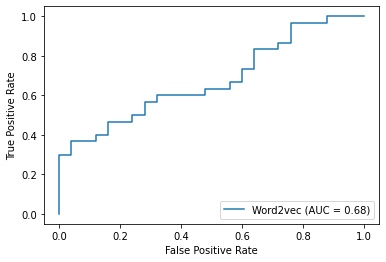

In [92]:
#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test[:55], prevs_prob[:55])

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.show()

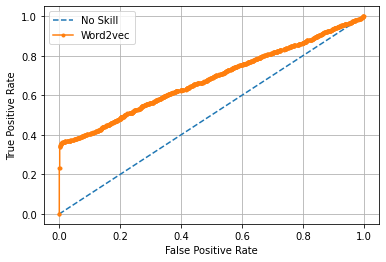

In [107]:
#roc curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test[:3000]))]

#roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_test[:3000], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test[:3000], prevs_prob[:3000])

#plot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Word2vec')

#axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

#legend
pyplot.legend()

#grid
pyplot.grid()

#save
plt.savefig(r'C:\Users\BeatrizCarvalho\Downloads\test\roc.png')

pyplot.show() 

In [96]:
#---------------------------------------------------density matrix------------------------------------------------------------#

#product of the matrices

#weight matrices
m1 = curr_model.wv.vectors
m2 = curr_model.syn1neg  #negative sampling
#m2 = model.syn1    #hierarchical-softmax 

mproduct = np.matmul(m1, m2.T)
mproduct.shape

(31015, 31015)

In [97]:
#apply softmax to obtain a matrix with conditional probabilities
conditional_probs = softmax(mproduct)

In [98]:
#visualize the 1st 20 lines and the last 20 lines of the density matrix

#1st 20 lines
conditional_aux = conditional_probs[:20].copy()

#last 20 lines
conditional_aux = np.concatenate((conditional_aux, conditional_probs[-20:].copy()))

In [99]:
#save density matrix - after the product and the softmax
pd.DataFrame(conditional_aux).to_csv(r'C:\Users\BeatrizCarvalho\Downloads\test\density_matrix.csv', header = None, index = False)

In [100]:
#-------------------------------------------------eigenvalues-----------------------------------------------------------------#

#singular eingenvalues of the square matrix - after the product and before softmax - w has the eigenvalues and v the eigenvectors
w, v = np.linalg.eig(mproduct)  #mproduct is an array of arrays

#separate real and imaginary parts of the singular eigenvalues
x = w.real  #array

y = w.imag  #array

In [101]:
#save eigenvalues in csv
df = pd.DataFrame({"Real" : x, "Imaginary" : y})

df.to_csv(r'C:\Users\BeatrizCarvalho\Downloads\test\eigenvalues.csv', index = False)